## 产品订单数据分析与需求预测

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# 使用 PD 1.5.3 
print("Pandas ",pd.__version__)

Pandas  1.5.3


In [3]:
# 如果大于 1.5.3 的话，删除
#!pip uninstall pandas -y

In [4]:
# 卸载之后重新安装
#!pip install pandas==1.5.3 -i https://mirrors.aliyun.com/pypi/simple/ 

In [5]:
#!pip install ydata_profiling -i https://mirrors.aliyun.com/pypi/simple/ 

In [6]:
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)


import plotly.graph_objs as go
from plotly.subplots import make_subplots
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb
import folium
from folium.plugins import HeatMap

import plotly.express as px
import datetime

from chinese_calendar import is_workday, is_holiday

In [7]:
!pwd

/Users/lincolnmac16/Documents/GitHub/PythonUtils/competition


In [8]:
import os
import sys
 
cur_dir = os.getcwd()
print("cur_dir",cur_dir)
pkg_rootdir = os.path.dirname(os.path.dirname(cur_dir))
# print(pkg_rootdir)
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)
sys.path.append('/Users/lincolnmac16/Documents/GitHub/PythonUtils/pandas_util')
print(sys.path)

cur_dir /Users/lincolnmac16/Documents/GitHub/PythonUtils/competition
['/Users/lincolnmac16/Documents/GitHub/PythonUtils/competition', '/Users/lincolnmac16/opt/anaconda3/envs/PythonUtils/lib/python38.zip', '/Users/lincolnmac16/opt/anaconda3/envs/PythonUtils/lib/python3.8', '/Users/lincolnmac16/opt/anaconda3/envs/PythonUtils/lib/python3.8/lib-dynload', '', '/Users/lincolnmac16/.local/lib/python3.8/site-packages', '/Users/lincolnmac16/opt/anaconda3/envs/PythonUtils/lib/python3.8/site-packages', '/Users/lincolnmac16/Documents/GitHub', '/Users/lincolnmac16/Documents/GitHub/PythonUtils/pandas_util']


In [9]:
from feature_analytis import *

In [10]:
data = pd.read_csv('order_train1.csv')

In [11]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(data, title="Profiling Report")
# profile.to_file("data_analysis.html")

In [12]:
#!pip install pygwalker -i https://mirrors.aliyun.com/pypi/simple/ 

In [13]:
# import pygwalker as pyg
# gwalker = pyg.walk(data)

# quantitative 定量的
# ordinal 序数
# dimension 维度
# measure 度量
# nominal 名词
# temporal 

MBA智库对3σ原则的描述：

σ代表标准差,μ代表均值

样本数据服从正态分布的情况下

数值分布在（μ-σ,μ+σ)中的概率为0.6826

数值分布在（μ-2σ,μ+2σ)中的概率为0.9544

数值分布在（μ-3σ,μ+3σ)中的概率为0.9974

可以认为，Y 的取值几乎全部集中在（μ-3σ,μ+3σ)区间内，超出这个范围的可能性仅占不到0.3%。

> https://www.guofei.site/2017/10/19/cleandata.html

In [14]:
# 在这里方法是对的，但是移除的列是不对的，销售区域代码出现的销售数量和售价太少了，所有就要删除掉吗？？？？

for region in data.sales_region_code.unique():
    indx1 = sigma3(data[data.sales_region_code==region]['ord_qty'])
    indx2 = sigma3(data[data.sales_region_code==region]['item_price'])
    indx = set(indx1).union(indx2)
  
    print("要删除的大小",len(indx))

    print("要删除的索引有")
    print(indx)
    data.drop(indx,axis=0,inplace=True)
# data['ord_qty'] = data['ord_qty'].interpolate(method='linear')

要删除的大小 633
要删除的索引有
{143361, 143364, 143366, 143367, 143368, 147470, 147482, 147485, 65571, 65578, 122932, 127048, 155728, 127060, 8291, 45164, 4213, 8316, 8319, 8320, 45192, 45209, 45213, 12461, 82103, 135355, 131259, 135361, 82126, 135376, 176342, 110808, 69862, 82155, 102639, 102640, 49396, 49397, 12537, 12538, 102652, 102653, 102654, 102655, 102656, 102657, 33025, 102660, 49414, 49420, 102668, 49423, 131346, 49427, 49428, 160021, 12569, 49435, 49443, 86313, 139564, 139569, 139570, 86324, 139574, 86338, 86346, 143695, 41296, 102737, 139624, 65897, 65898, 65900, 65904, 143728, 41330, 139635, 139637, 143734, 65911, 143745, 143748, 65926, 143784, 90545, 156098, 74180, 106957, 135635, 135641, 135650, 33251, 127460, 127467, 135661, 66031, 25087, 115203, 12825, 131631, 12853, 45624, 45637, 45638, 78415, 78416, 78433, 148080, 148085, 168569, 86650, 148091, 148090, 82556, 127619, 49830, 131750, 49835, 86700, 148141, 49839, 62138, 94906, 94911, 144065, 33488, 172752, 90835, 86747, 49887, 6627

## feature engeering

### 月份处理

In [15]:

# 下面的这个方法是因为赛题的原因，因为题目中是从 2015 年开始的。
def month_num(date):
    if date.year==2015:
        month_num = date.month-9
    else:
        month_num = 3 + date.month + (date.year-2016)*12
    return month_num

### 时间处理

In [16]:
data = time_feature(data,'order_date')
data['month_num'] = data['order_date'].apply(month_num)
data

order_date  sales_region_code  item_code  first_cate_code  \
0      2015-09-01                104      22069              307   
1      2015-09-01                104      20028              301   
2      2015-09-02                104      21183              307   
3      2015-09-02                104      20448              308   
4      2015-09-02                104      21565              307   
...           ...                ...        ...              ...   
597689 2018-12-20                102      20994              302   
597690 2018-12-20                102      21875              302   
597691 2018-12-20                102      20215              302   
597692 2018-12-20                102      20195              302   
597693 2018-12-20                102      20321              302   

        second_cate_code sales_chan_name  item_price  ord_qty  dayofmonth  \
0                    403         offline      1114.0       19           1   
1                    405         offline      1012.0       12           1   
2                    403          online       428.0      109           2   
3                    404          online       962.0        3           2   
4                    403         offline      1400.0        3           2   
...                  ...             ...         ...      ...         ...   
597689               408         offline       843.0       59          20   
597690               408         offline       762.0      502          20   
597691               408         offline      2013.0      106          20   
597692               408         offline      2120.0      187          20   
597693               408         offline      1244.0      205          20   

        dayofweek  month  year  is_month_start  is_month_end  is_workday  \
0               1      9  2015               1             0           1   
1               1      9  2015               1             0           1   
2               2      9  2015               0             0           1   
3               2      9  2015               0             0           1   
4               2      9  2015               0             0           1   
...           ...    ...   ...             ...           ...         ...   
597689          3     12  2018               0             0           1   
597690          3     12  2018               0             0           1   
597691          3     12  2018               0             0           1   
597692          3     12  2018               0             0           1   
597693          3     12  2018               0             0           1   

        is_holiday  in_quarter  in_month_stage  month_num  
0                0           3               0          0  
1                0           3               0          0  
2                0           3               0          0  
3                0           3               0          0  
4                0           3               0          0  
...            ...         ...             ...        ...  
597689           0           4               1         39  
597690           0           4               1         39  
597691           0           4               1         39  
597692           0           4               1         39  
597693           0           4               1         39  

[582614 rows x 19 columns]

### 价格区间处理

In [17]:
def price_range(data):
    if data<500:
        return 0
    elif (data>=500) and (data<1000):
        return 1
    elif (data>=1000) and (data<1500):
        return 2
    else:
        return 3

In [18]:
data['sales_chan_name'] = data['sales_chan_name'].map({'offline':0,'online':1})

In [19]:
data['region_chan'] = data['sales_region_code'].apply(str) + '-' + data['sales_chan_name'].apply(str)

In [20]:
# 按照价格分割
bins = [0,500,1000,1500,100000000]
labels = [0,1,2,3]
data = segments_bins_labels(data,'item_price',bins,labels)
data

order_date  sales_region_code  item_code  first_cate_code  \
0      2015-09-01                104      22069              307   
1      2015-09-01                104      20028              301   
2      2015-09-02                104      21183              307   
3      2015-09-02                104      20448              308   
4      2015-09-02                104      21565              307   
...           ...                ...        ...              ...   
597689 2018-12-20                102      20994              302   
597690 2018-12-20                102      21875              302   
597691 2018-12-20                102      20215              302   
597692 2018-12-20                102      20195              302   
597693 2018-12-20                102      20321              302   

        second_cate_code  sales_chan_name  item_price  ord_qty  dayofmonth  \
0                    403                0      1114.0       19           1   
1                    405                0      1012.0       12           1   
2                    403                1       428.0      109           2   
3                    404                1       962.0        3           2   
4                    403                0      1400.0        3           2   
...                  ...              ...         ...      ...         ...   
597689               408                0       843.0       59          20   
597690               408                0       762.0      502          20   
597691               408                0      2013.0      106          20   
597692               408                0      2120.0      187          20   
597693               408                0      1244.0      205          20   

        dayofweek  ...  year  is_month_start  is_month_end  is_workday  \
0               1  ...  2015               1             0           1   
1               1  ...  2015               1             0           1   
2               2  ...  2015               0             0           1   
3               2  ...  2015               0             0           1   
4               2  ...  2015               0             0           1   
...           ...  ...   ...             ...           ...         ...   
597689          3  ...  2018               0             0           1   
597690          3  ...  2018               0             0           1   
597691          3  ...  2018               0             0           1   
597692          3  ...  2018               0             0           1   
597693          3  ...  2018               0             0           1   

        is_holiday  in_quarter  in_month_stage  month_num  region_chan  \
0                0           3               0          0        104-0   
1                0           3               0          0        104-0   
2                0           3               0          0        104-1   
3                0           3               0          0        104-1   
4                0           3               0          0        104-0   
...            ...         ...             ...        ...          ...   
597689           0           4               1         39        102-0   
597690           0           4               1         39        102-0   
597691           0           4               1         39        102-0   
597692           0           4               1         39        102-0   
597693           0           4               1         39        102-0   

       segements_item_price  
0              (1000, 1500]  
1              (1000, 1500]  
2                  (0, 500]  
3               (500, 1000]  
4              (1000, 1500]  
...                     ...  
597689          (500, 1000]  
597690          (500, 1000]  
597691    (1500, 100000000]  
597692    (1500, 100000000]  
597693         (1000, 1500]  

[582614 rows x 21 columns]

In [21]:
data.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty',
       'dayofmonth', 'dayofweek', 'month', 'year', 'is_month_start',
       'is_month_end', 'is_workday', 'is_holiday', 'in_quarter',
       'in_month_stage', 'month_num', 'region_chan', 'segements_item_price'],
      dtype='object')

########################## Column order_date##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---order_date 描述性信息统计---
count                  582614
unique                   1172
top       2018-11-22 00:00:00
freq                     1519
first     2015-09-01 00:00:00
last      2018-12-20 00:00:00
Name: order_date, dtype: object


order_date 列中的唯一值和数量如下：

2018-11-22    1519
2017-05-25    1507
2018-09-30    1497
2018-10-30    1421
2016-09-16    1413
              ... 
2015-09-02      10
2016-02-03       5
2017-02-03       2
2016-04-04       2
2015-09-01       2
Name: order_date, Length: 1172, dtype: int

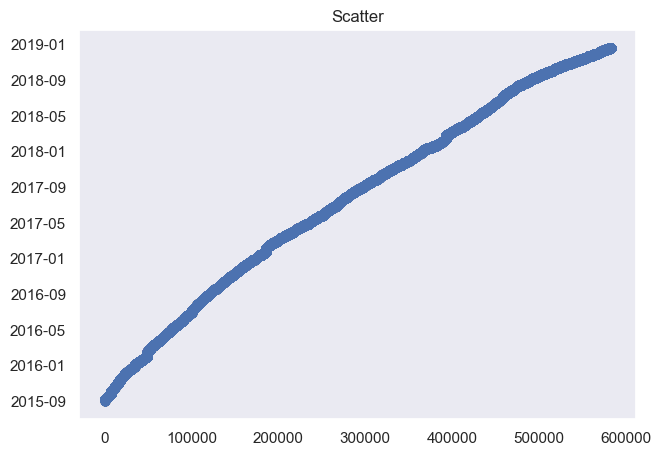

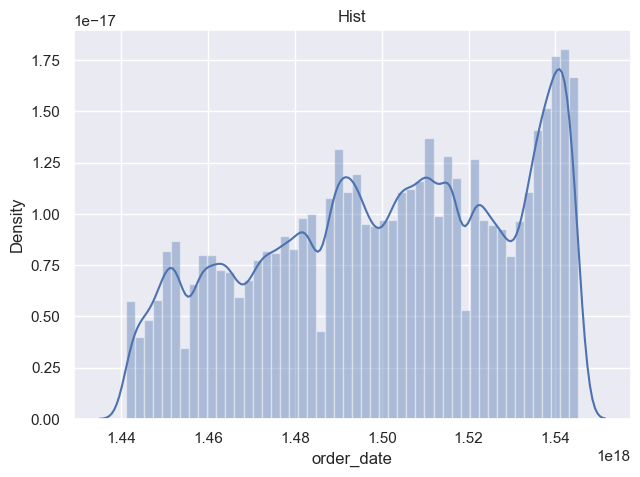


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('O')
---频率分布情况---


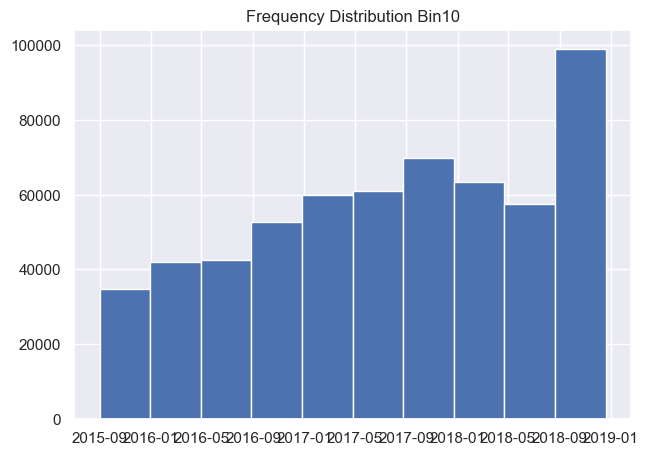

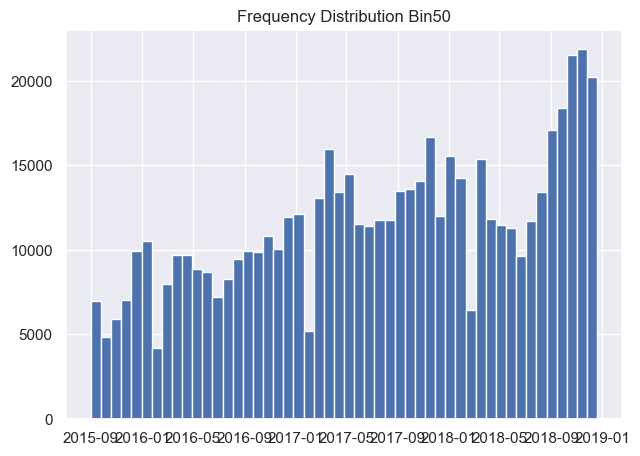

---分组区间---
0    [2015-09-01, 2015-12-30 14:24:00)
1    [2015-09-01, 2015-12-30 14:24:00)
2    [2015-09-01, 2015-12-30 14:24:00)
3    [2015-09-01, 2015-12-30 14:24:00)
4    [2015-09-01, 2015-12-30 14:24:00)
Name: order_date, dtype: category
Categories (10, interval[datetime64[ns], left]): [[2015-09-01, 2015-12-30 14:24:00) < [2015-12-30 14:24:00, 2016-04-29 04:48:00) < [2016-04-29 04:48:00, 2016-08-27 19:12:00) < [2016-08-27 19:12:00, 2016-12-26 09:36:00) ... [2017-08-24 14:24:00, 2017-12-23 04:48:00) < [2017-12-23 04:48:00, 2018-04-22 19:12:00) < [2018-04-22 19:12:00, 2018-08-21 09:36:00) < [2018-08-21 09:36:00, 2018-12-21 04:56:38.400000)] 
------
[2015-09-01, 2015-12-30 14:24:00)                    34681
[2015-12-30 14:24:00, 2016-04-29 04:48:00)           42106
[2016-04-29 04:48:00, 2016-08-27 19:12:00)           42449
[2016-08-27 19:12:00, 2016-12-26 09:36:00)           52556
[2016-12-26 09:36:00, 2017-04-26)                    59838
[2017-04-26, 2017-08-24 14:24:00)               

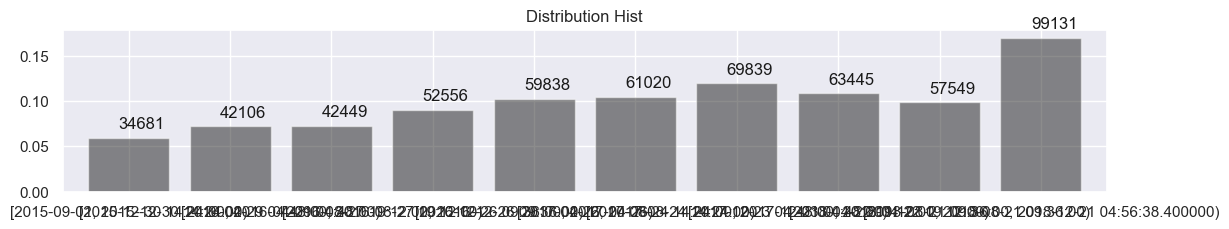

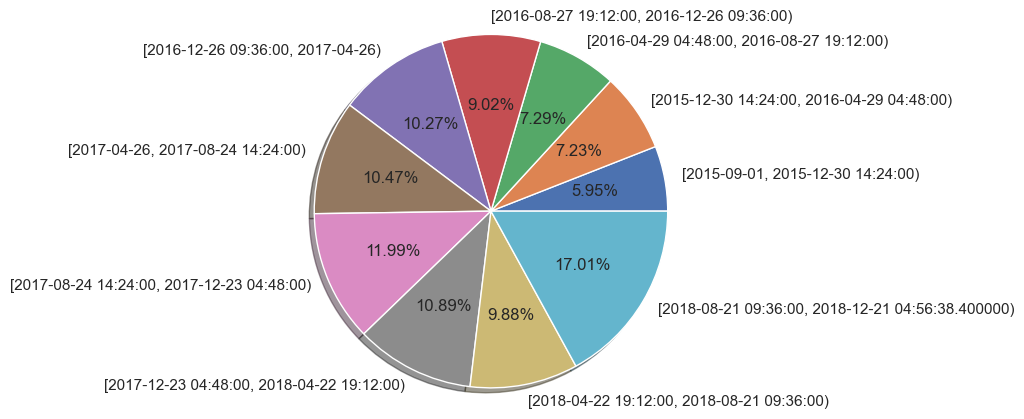

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         1441065600000000000
1         1441065600000000000
2         1441152000000000000
3         1441152000000000000
4         1441152000000000000
                 ...         
597689    1545264000000000000
597690    1545264000000000000
597691    1545264000000000000
597692    1545264000000000000
597693    1545264000000000000
Name: order_date, Length: 582614, dtype: int64


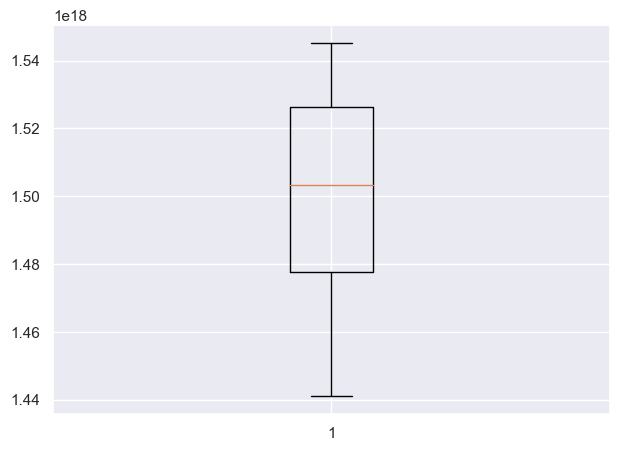




########################## Column sales_region_code##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---sales_region_code 描述性信息统计---
count    582614.000000
mean        102.905720
std           1.505167
min         101.000000
25%         102.000000
50%         103.000000
75%         105.000000
max         105.000000
Name: sales_region_code, dtype: float64


sales_region_code 列中的唯一值和数量如下：

105    162667
102    159379
101    122657
103    113481
104     24430
Name: sales_region_code, dtype: int64


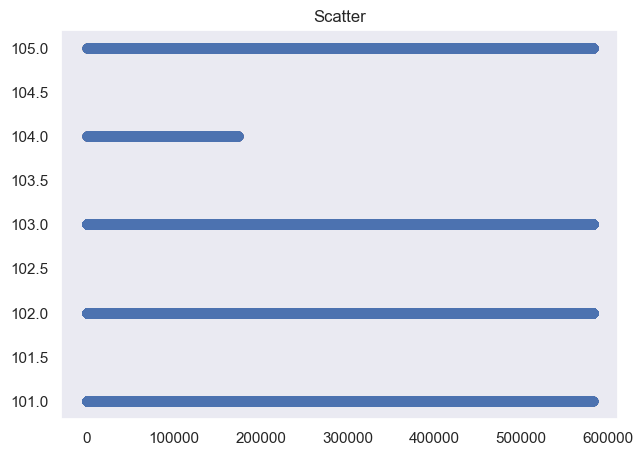

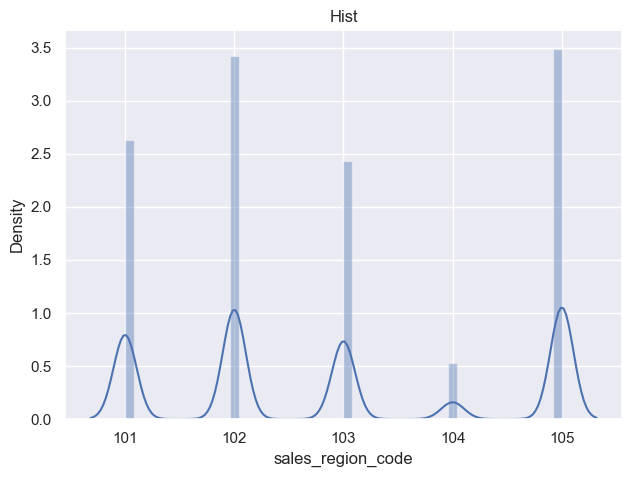


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.2104137162599939, pvalue=0.0)
变量极差	Max(105.000000)-Min(101.000000) = 4.000000
---频率分布情况---


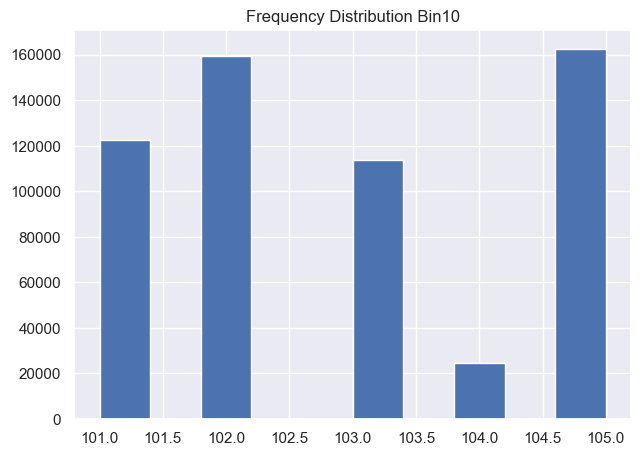

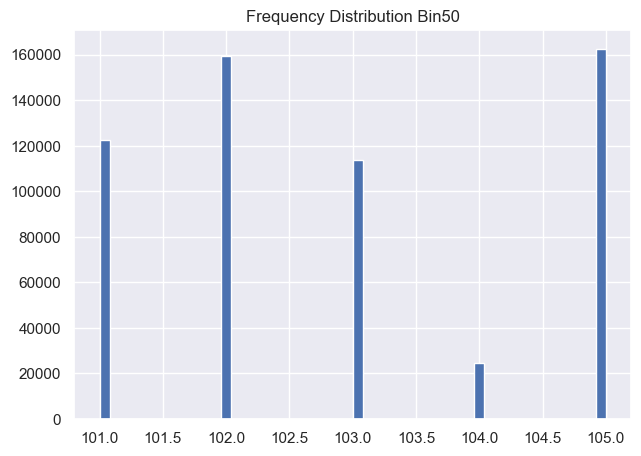

---分组区间---
0    [103.8, 104.2)
1    [103.8, 104.2)
2    [103.8, 104.2)
3    [103.8, 104.2)
4    [103.8, 104.2)
Name: sales_region_code, dtype: category
Categories (10, interval[float64, left]): [[101.0, 101.4) < [101.4, 101.8) < [101.8, 102.2) < [102.2, 102.6) ... [103.4, 103.8) < [103.8, 104.2) < [104.2, 104.6) < [104.6, 105.004)] 
------
[101.0, 101.4)      122657
[101.4, 101.8)           0
[101.8, 102.2)      159379
[102.2, 102.6)           0
[102.6, 103.0)           0
[103.0, 103.4)      113481
[103.4, 103.8)           0
[103.8, 104.2)       24430
[104.2, 104.6)           0
[104.6, 105.004)    162667
Name: sales_region_code, dtype: int64
0    104
1    104
2    104
3    104
4    104
Name: sales_region_code, dtype: int64
---输出频*表---
                      频数        频率      累计频率     频率%    累计频率%
[101.0, 101.4)    122657  0.210529  0.210529  21.05%   21.05%
[101.4, 101.8)         0  0.000000  0.210529   0.00%   21.05%
[101.8, 102.2)    159379  0.273558  0.484087  27.36%   48.41%
[102.2,

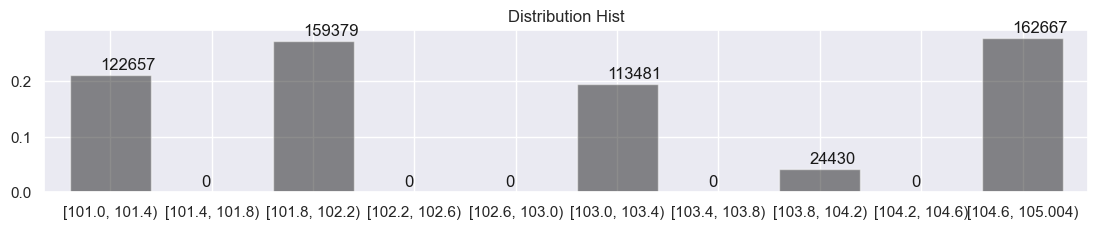

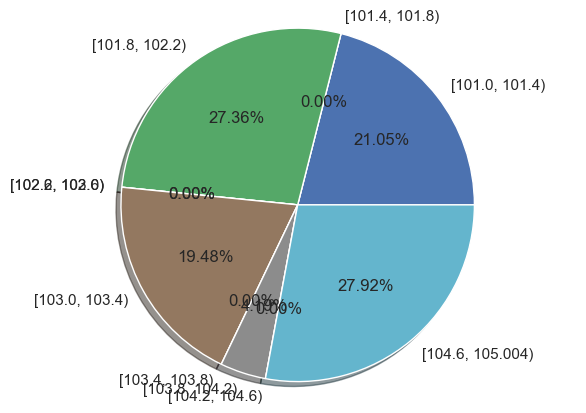

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         104
1         104
2         104
3         104
4         104
         ... 
597689    102
597690    102
597691    102
597692    102
597693    102
Name: sales_region_code, Length: 582614, dtype: int64


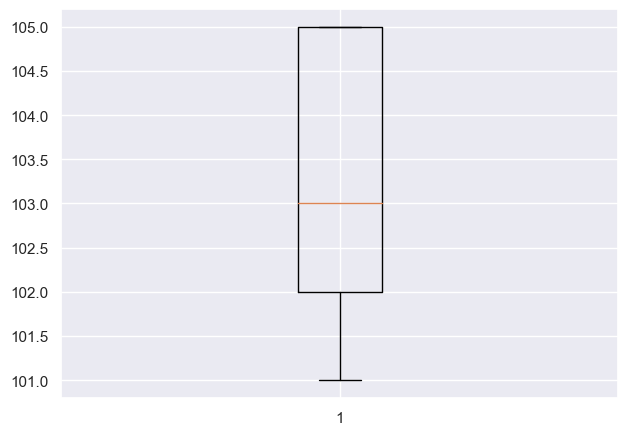




########################## Column item_code##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---item_code 描述性信息统计---
count    582614.000000
mean      21005.371778
std         592.093968
min       20001.000000
25%       20512.000000
50%       20973.000000
75%       21519.000000
max       22084.000000
Name: item_code, dtype: float64


item_code 列中的唯一值和数量如下：

20973    7768
21271    7658
21619    5721
20501    5350
20283    4675
         ... 
21218       1
20395       1
20708       1
20307       1
21320       1
Name: item_code, Length: 1740, dtype: int64


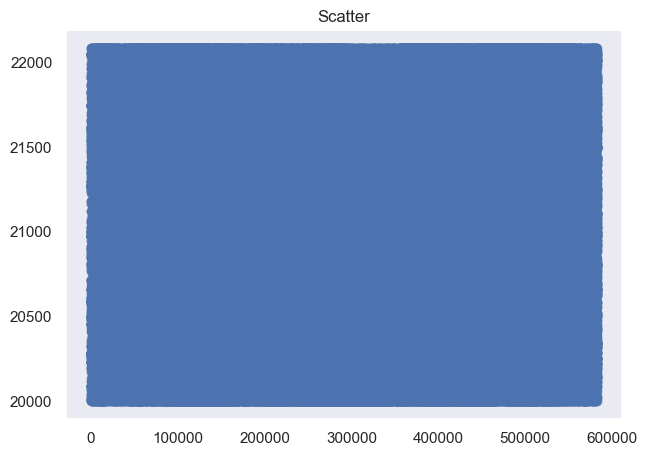

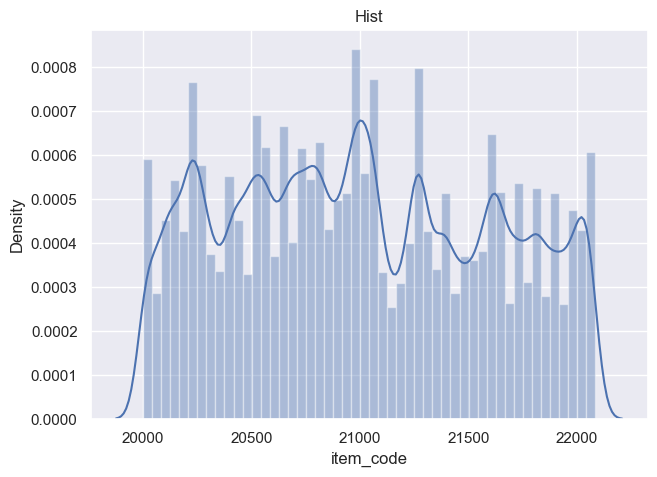


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.06102996797195703, pvalue=0.0)
变量极差	Max(22084.000000)-Min(20001.000000) = 2083.000000
---频率分布情况---


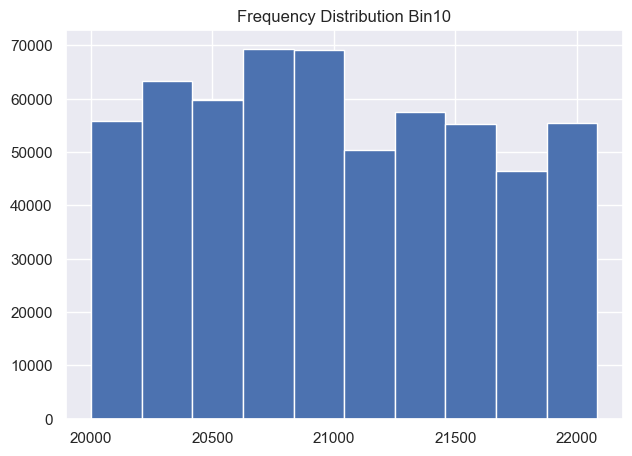

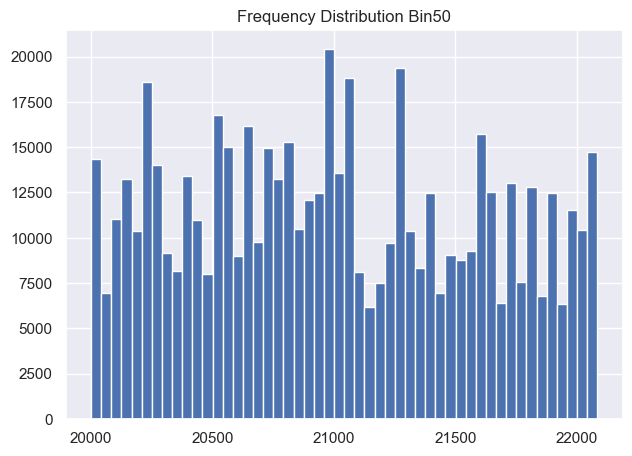

---分组区间---
0    [21875.7, 22086.083)
1      [20001.0, 20209.3)
2      [21042.5, 21250.8)
3      [20417.6, 20625.9)
4      [21459.1, 21667.4)
Name: item_code, dtype: category
Categories (10, interval[float64, left]): [[20001.0, 20209.3) < [20209.3, 20417.6) < [20417.6, 20625.9) < [20625.9, 20834.2) ... [21250.8, 21459.1) < [21459.1, 21667.4) < [21667.4, 21875.7) < [21875.7, 22086.083)] 
------
[20001.0, 20209.3)      55908
[20209.3, 20417.6)      63330
[20417.6, 20625.9)      59732
[20625.9, 20834.2)      69427
[20834.2, 21042.5)      69071
[21042.5, 21250.8)      50316
[21250.8, 21459.1)      57451
[21459.1, 21667.4)      55299
[21667.4, 21875.7)      46531
[21875.7, 22086.083)    55549
Name: item_code, dtype: int64
0    22069
1    20028
2    21183
3    20448
4    21565
Name: item_code, dtype: int64
---输出频*表---
                         频数        频率      累计频率     频率%    累计频率%
[20001.0, 20209.3)    55908  0.095961  0.095961   9.60%    9.60%
[20209.3, 20417.6)    63330  0.108700  0.204660

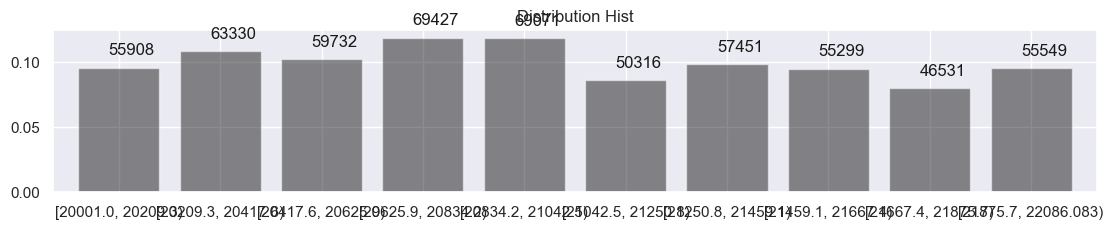

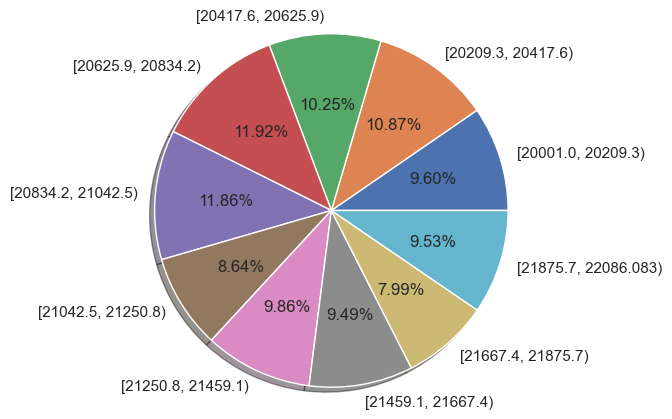

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         22069
1         20028
2         21183
3         20448
4         21565
          ...  
597689    20994
597690    21875
597691    20215
597692    20195
597693    20321
Name: item_code, Length: 582614, dtype: int64


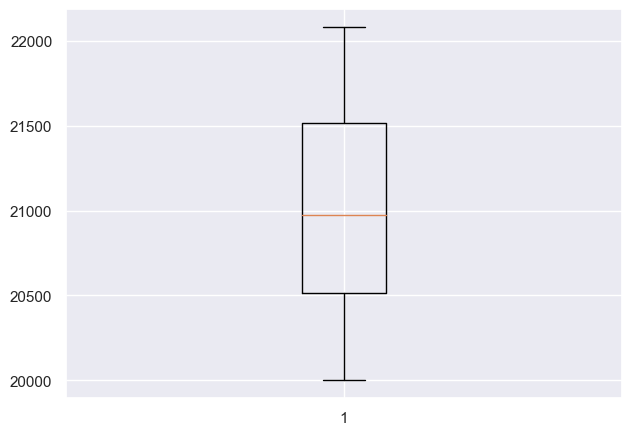




########################## Column first_cate_code##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---first_cate_code 描述性信息统计---
count    582614.000000
mean        304.930072
std           2.006596
min         301.000000
25%         303.000000
50%         306.000000
75%         306.000000
max         308.000000
Name: first_cate_code, dtype: float64


first_cate_code 列中的唯一值和数量如下：

306    213909
302     93432
305     73959
303     68270
308     52530
307     49616
301     21246
304      9652
Name: first_cate_code, dtype: int64


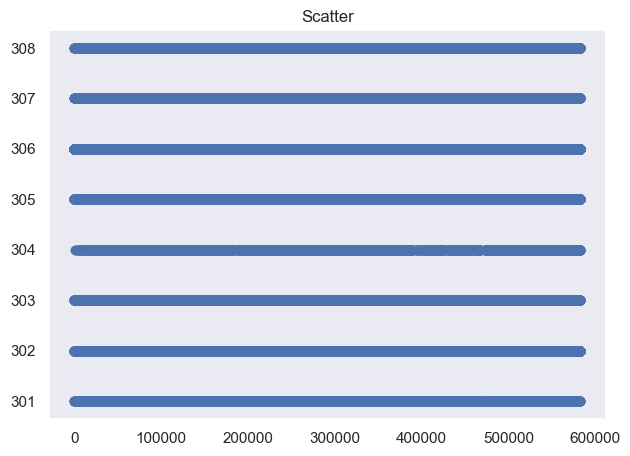

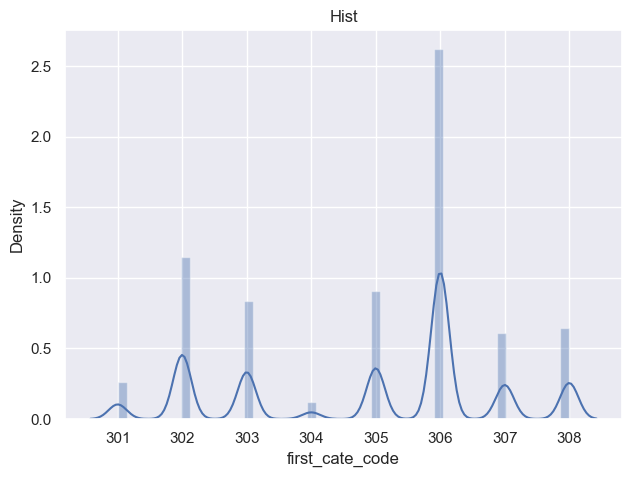


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.24553180137096065, pvalue=0.0)
变量极差	Max(308.000000)-Min(301.000000) = 7.000000
---频率分布情况---


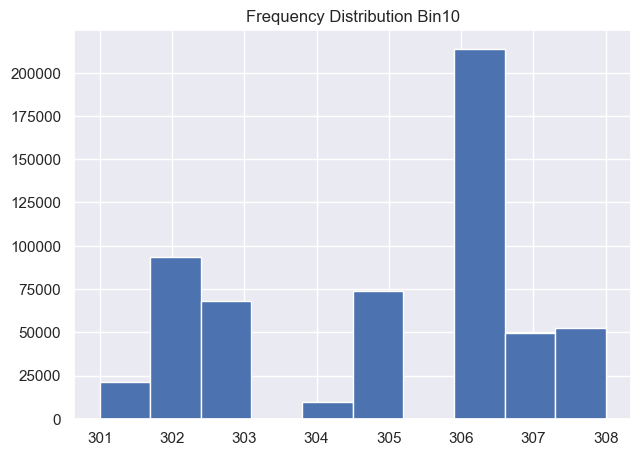

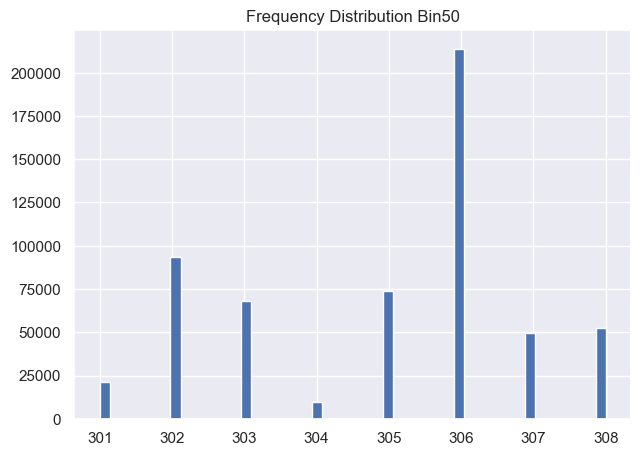

---分组区间---
0      [306.6, 307.3)
1      [301.0, 301.7)
2      [306.6, 307.3)
3    [307.3, 308.007)
4      [306.6, 307.3)
Name: first_cate_code, dtype: category
Categories (10, interval[float64, left]): [[301.0, 301.7) < [301.7, 302.4) < [302.4, 303.1) < [303.1, 303.8) ... [305.2, 305.9) < [305.9, 306.6) < [306.6, 307.3) < [307.3, 308.007)] 
------
[301.0, 301.7)       21246
[301.7, 302.4)       93432
[302.4, 303.1)       68270
[303.1, 303.8)           0
[303.8, 304.5)        9652
[304.5, 305.2)       73959
[305.2, 305.9)           0
[305.9, 306.6)      213909
[306.6, 307.3)       49616
[307.3, 308.007)     52530
Name: first_cate_code, dtype: int64
0    307
1    301
2    307
3    308
4    307
Name: first_cate_code, dtype: int64
---输出频*表---
                      频数        频率      累计频率     频率%    累计频率%
[301.0, 301.7)     21246  0.036467  0.036467   3.65%    3.65%
[301.7, 302.4)     93432  0.160367  0.196834  16.04%   19.68%
[302.4, 303.1)     68270  0.117179  0.314012  11.72%   31.40%
[30

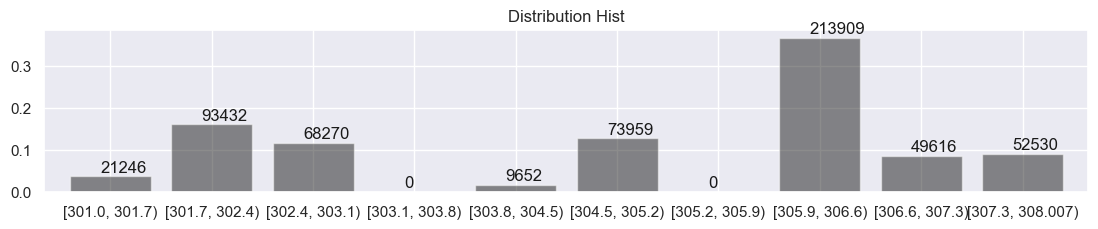

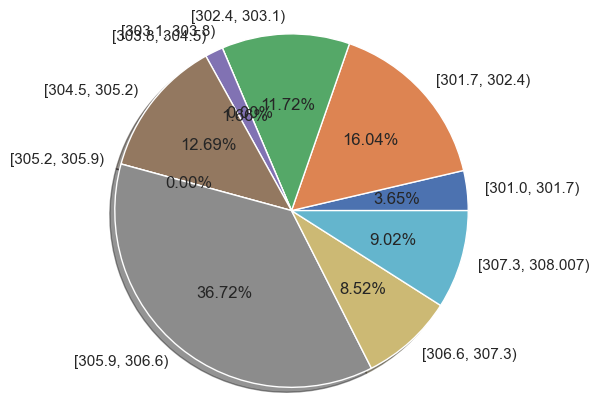

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         307
1         301
2         307
3         308
4         307
         ... 
597689    302
597690    302
597691    302
597692    302
597693    302
Name: first_cate_code, Length: 582614, dtype: int64


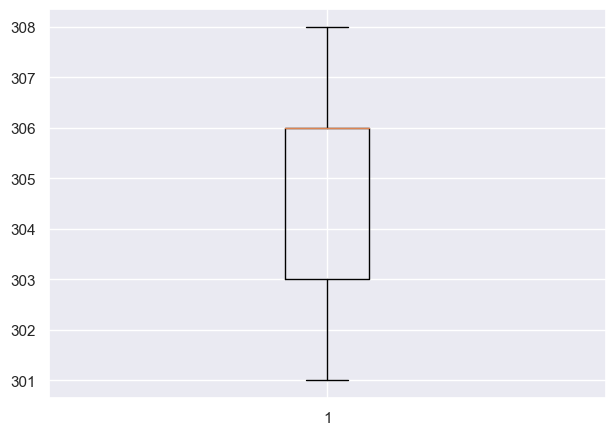




########################## Column second_cate_code##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---second_cate_code 描述性信息统计---
count    582614.000000
mean        406.455065
std           3.105720
min         401.000000
25%         404.000000
50%         407.000000
75%         408.000000
max         412.000000
Name: second_cate_code, dtype: float64


second_cate_code 列中的唯一值和数量如下：

407    202481
408     93432
412     73959
401     58924
404     52530
403     49616
405     21246
402     11428
409      9652
406      5034
410      3002
411      1310
Name: second_cate_code, dtype: int64


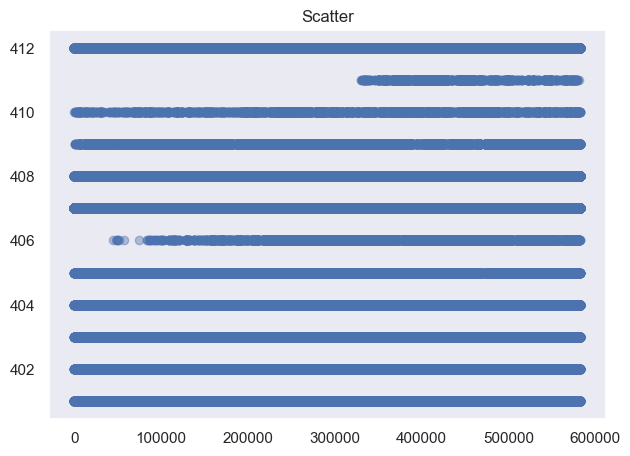

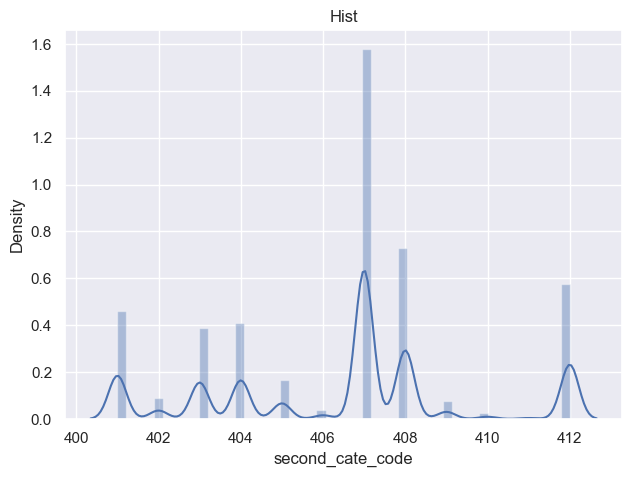


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.22845862304198683, pvalue=0.0)
变量极差	Max(412.000000)-Min(401.000000) = 11.000000
---频率分布情况---


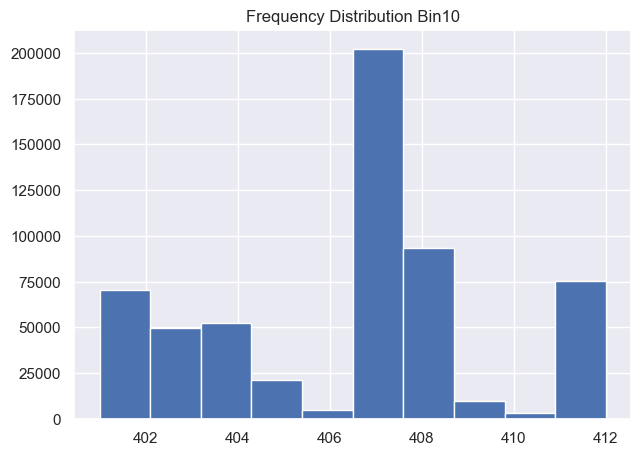

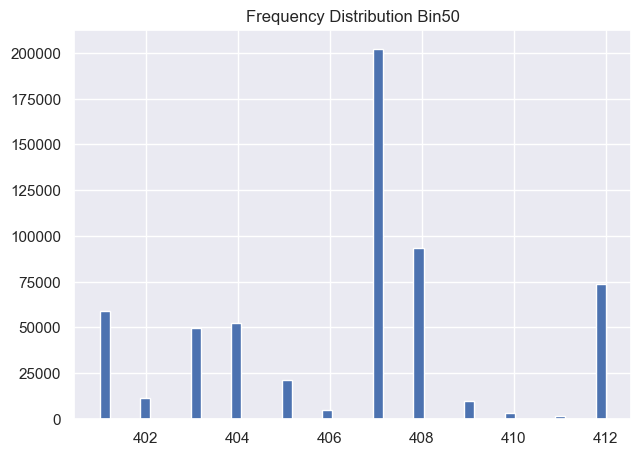

---分组区间---
0    [402.1, 403.2)
1    [404.3, 405.4)
2    [402.1, 403.2)
3    [403.2, 404.3)
4    [402.1, 403.2)
Name: second_cate_code, dtype: category
Categories (10, interval[float64, left]): [[401.0, 402.1) < [402.1, 403.2) < [403.2, 404.3) < [404.3, 405.4) ... [407.6, 408.7) < [408.7, 409.8) < [409.8, 410.9) < [410.9, 412.011)] 
------
[401.0, 402.1)       70352
[402.1, 403.2)       49616
[403.2, 404.3)       52530
[404.3, 405.4)       21246
[405.4, 406.5)        5034
[406.5, 407.6)      202481
[407.6, 408.7)       93432
[408.7, 409.8)        9652
[409.8, 410.9)        3002
[410.9, 412.011)     75269
Name: second_cate_code, dtype: int64
0    403
1    405
2    403
3    404
4    403
Name: second_cate_code, dtype: int64
---输出频*表---
                      频数        频率      累计频率     频率%    累计频率%
[401.0, 402.1)     70352  0.120752  0.120752  12.08%   12.08%
[402.1, 403.2)     49616  0.085161  0.205913   8.52%   20.59%
[403.2, 404.3)     52530  0.090163  0.296076   9.02%   29.61%
[404.3, 40

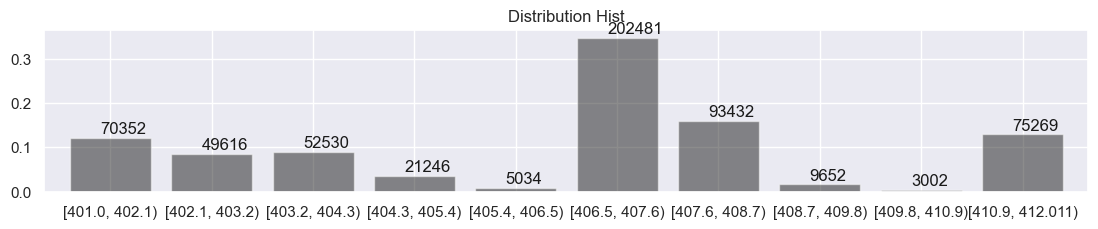

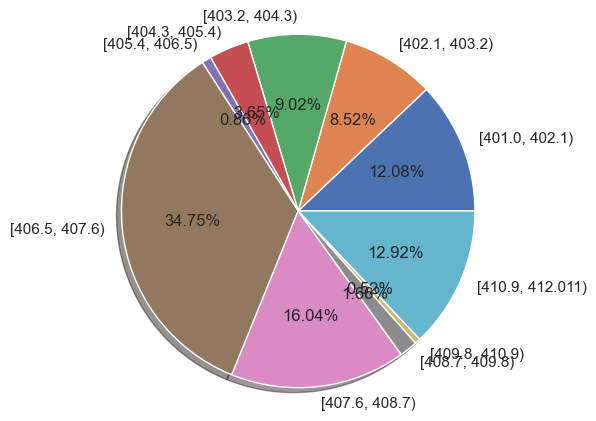

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         403
1         405
2         403
3         404
4         403
         ... 
597689    408
597690    408
597691    408
597692    408
597693    408
Name: second_cate_code, Length: 582614, dtype: int64


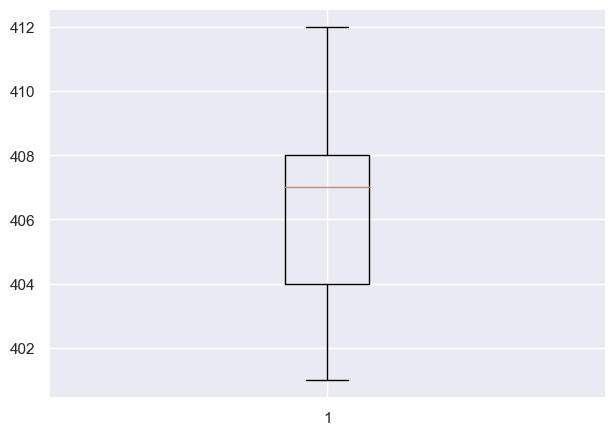




########################## Column sales_chan_name##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---sales_chan_name 描述性信息统计---
count    582614.000000
mean          0.263732
std           0.440656
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: sales_chan_name, dtype: float64


sales_chan_name 列中的唯一值和数量如下：

0    428960
1    153654
Name: sales_chan_name, dtype: int64


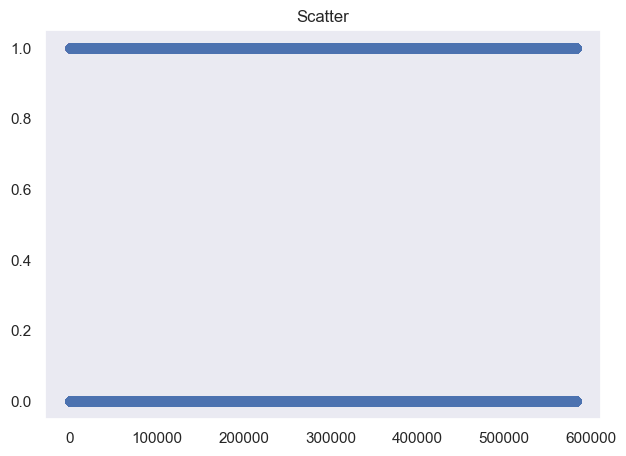

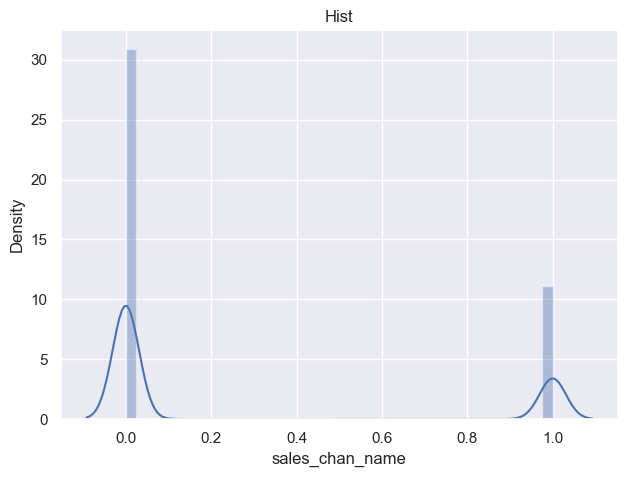


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.4615142888006562, pvalue=0.0)
变量极差	Max(1.000000)-Min(0.000000) = 1.000000
---频率分布情况---


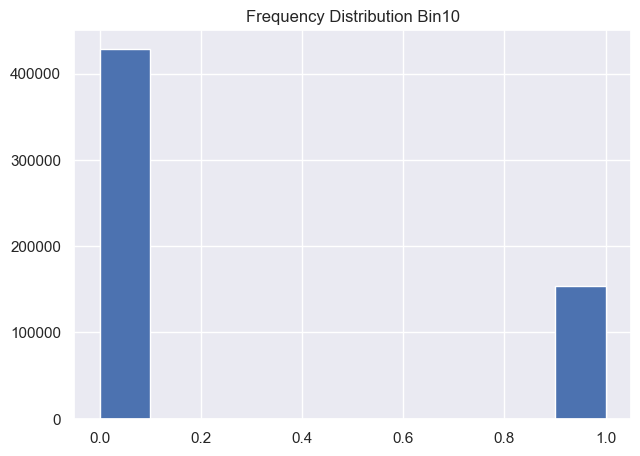

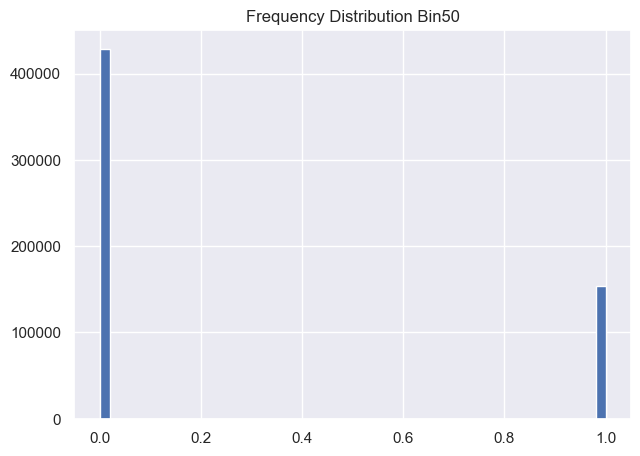

---分组区间---
0      [0.0, 0.1)
1      [0.0, 0.1)
2    [0.9, 1.001)
3    [0.9, 1.001)
4      [0.0, 0.1)
Name: sales_chan_name, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.1) < [0.1, 0.2) < [0.2, 0.3) < [0.3, 0.4) ... [0.6, 0.7) < [0.7, 0.8) < [0.8, 0.9) < [0.9, 1.001)] 
------
[0.0, 0.1)      428960
[0.1, 0.2)           0
[0.2, 0.3)           0
[0.3, 0.4)           0
[0.4, 0.5)           0
[0.5, 0.6)           0
[0.6, 0.7)           0
[0.7, 0.8)           0
[0.8, 0.9)           0
[0.9, 1.001)    153654
Name: sales_chan_name, dtype: int64
0    0
1    0
2    1
3    1
4    0
Name: sales_chan_name, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[0.0, 0.1)    428960  0.736268  0.736268  73.63%   73.63%
[0.1, 0.2)         0  0.000000  0.736268   0.00%   73.63%
[0.2, 0.3)         0  0.000000  0.736268   0.00%   73.63%
[0.3, 0.4)         0  0.000000  0.736268   0.00%   73.63%
[0.4, 0.5)         0  0.000000  0.736268   0.00%   73.63%
[0.5,

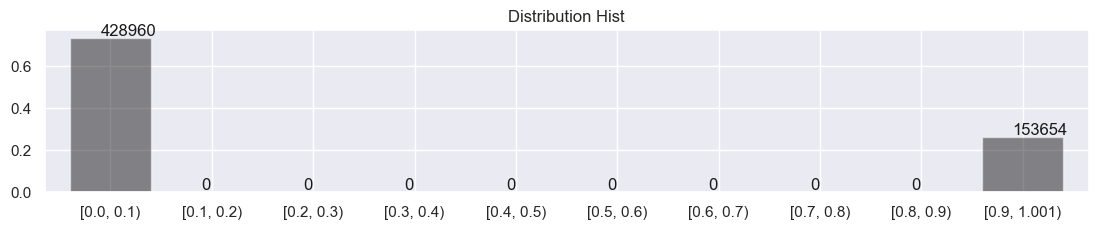

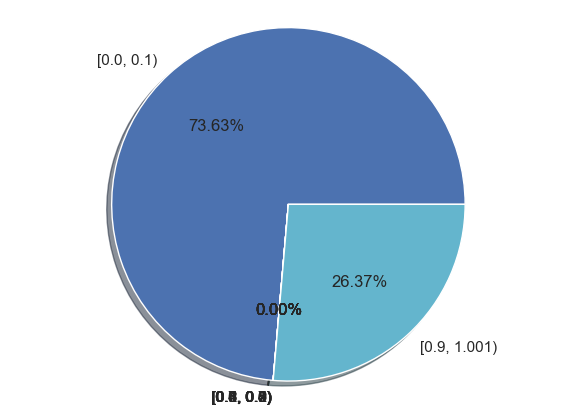

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         0
1         0
2         1
3         1
4         0
         ..
597689    0
597690    0
597691    0
597692    0
597693    0
Name: sales_chan_name, Length: 582614, dtype: int64


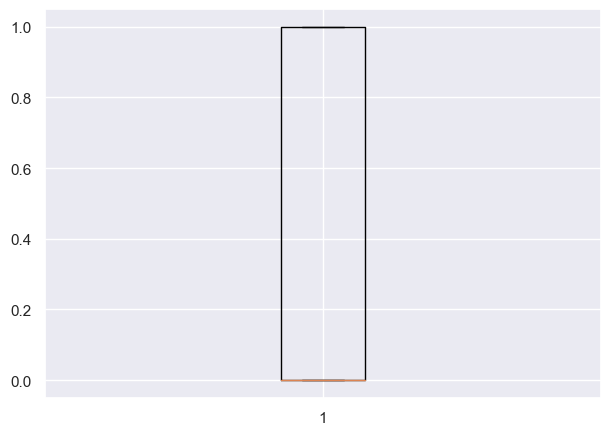




########################## Column item_price##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---item_price 描述性信息统计---
count    582614.000000
mean       1036.925431
std         651.115473
min           1.000000
25%         602.000000
50%         885.000000
75%        1284.725000
max        5900.000000
Name: item_price, dtype: float64


item_price 列中的唯一值和数量如下：

762.00     789
761.00     788
766.00     783
541.00     775
764.00     765
          ... 
862.51       1
1029.24      1
1143.88      1
2221.52      1
3642.28      1
Name: item_price, Length: 13211, dtype: int64


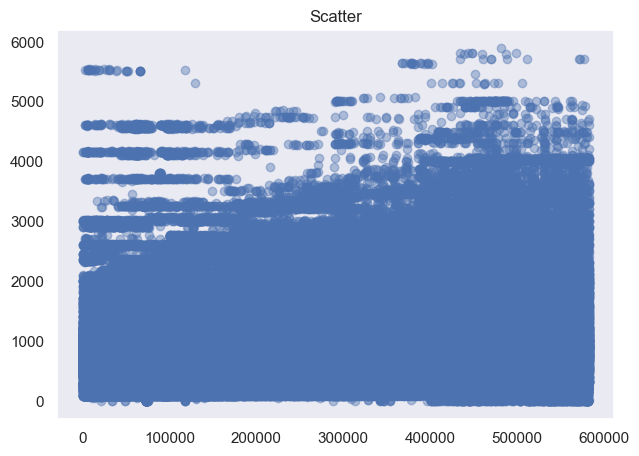

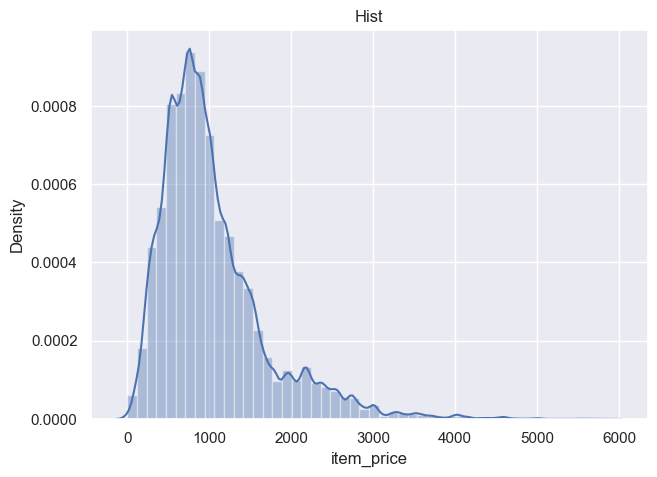


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.12445373586896613, pvalue=0.0)
变量极差	Max(5900.000000)-Min(1.000000) = 5899.000000
---频率分布情况---


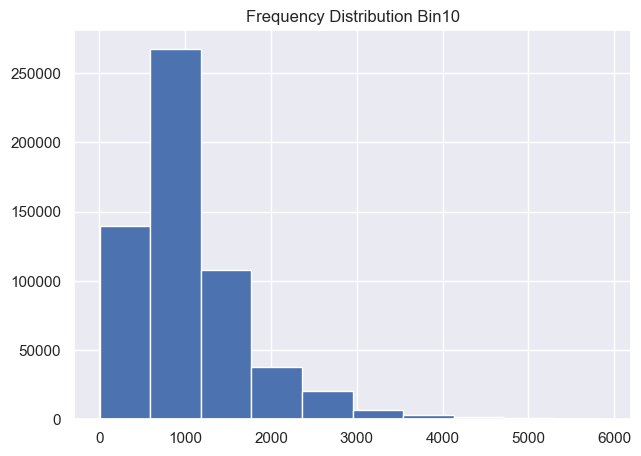

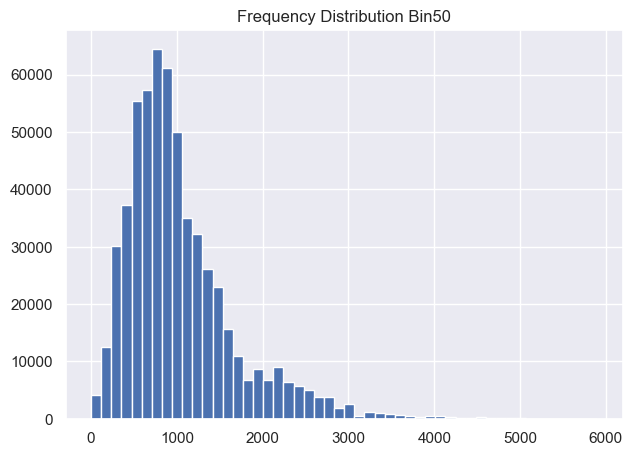

---分组区间---
0     [590.9, 1180.8)
1     [590.9, 1180.8)
2        [1.0, 590.9)
3     [590.9, 1180.8)
4    [1180.8, 1770.7)
Name: item_price, dtype: category
Categories (10, interval[float64, left]): [[1.0, 590.9) < [590.9, 1180.8) < [1180.8, 1770.7) < [1770.7, 2360.6) ... [3540.4, 4130.3) < [4130.3, 4720.2) < [4720.2, 5310.1) < [5310.1, 5905.899)] 
------
[1.0, 590.9)          139394
[590.9, 1180.8)       267947
[1180.8, 1770.7)      107616
[1770.7, 2360.6)       37511
[2360.6, 2950.5)       20056
[2950.5, 3540.4)        6172
[3540.4, 4130.3)        2565
[4130.3, 4720.2)        1036
[4720.2, 5310.1)         242
[5310.1, 5905.899)        75
Name: item_price, dtype: int64
0    1114.0
1    1012.0
2     428.0
3     962.0
4    1400.0
Name: item_price, dtype: float64
---输出频*表---
                        频数        频率      累计频率     频率%    累计频率%
[1.0, 590.9)        139394  0.239256  0.239256  23.93%   23.93%
[590.9, 1180.8)     267947  0.459905  0.699161  45.99%   69.92%
[1180.8, 1770.7)    107616

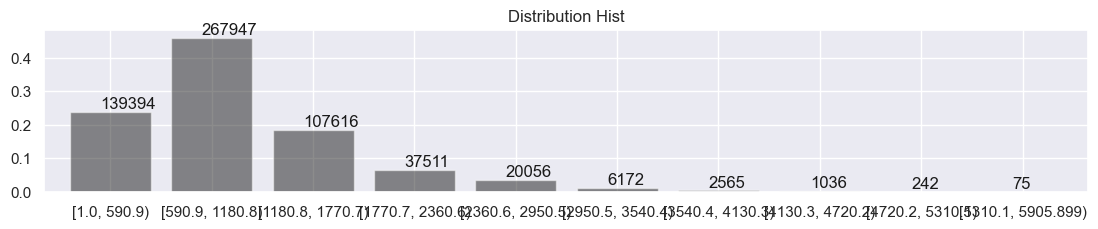

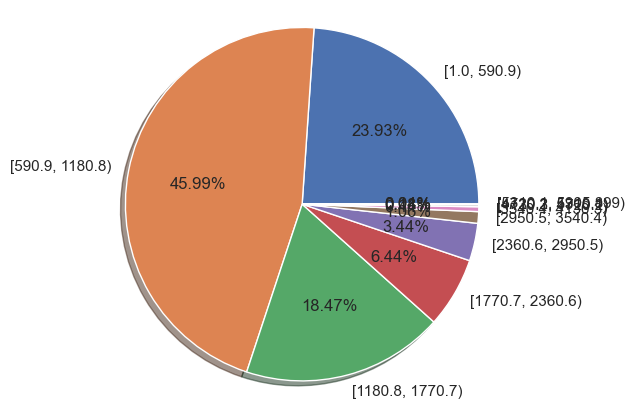

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         1114.0
1         1012.0
2          428.0
3          962.0
4         1400.0
           ...  
597689     843.0
597690     762.0
597691    2013.0
597692    2120.0
597693    1244.0
Name: item_price, Length: 582614, dtype: float64


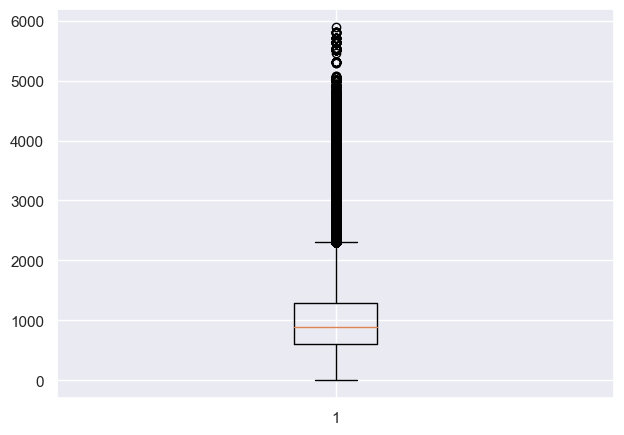




########################## Column ord_qty##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---ord_qty 描述性信息统计---
count    582614.000000
mean         73.220820
std         109.006007
min           1.000000
25%          10.000000
50%          28.000000
75%          92.000000
max         797.000000
Name: ord_qty, dtype: float64


ord_qty 列中的唯一值和数量如下：

9      21241
10     20958
8      20701
7      20166
6      19168
       ...  
777        1
774        1
775        1
784        1
720        1
Name: ord_qty, Length: 796, dtype: int64


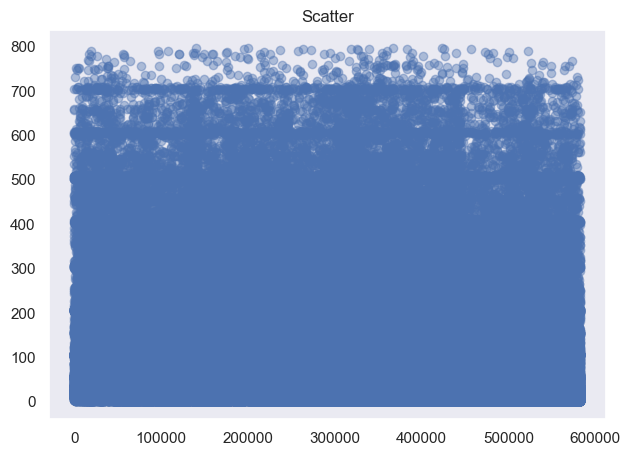

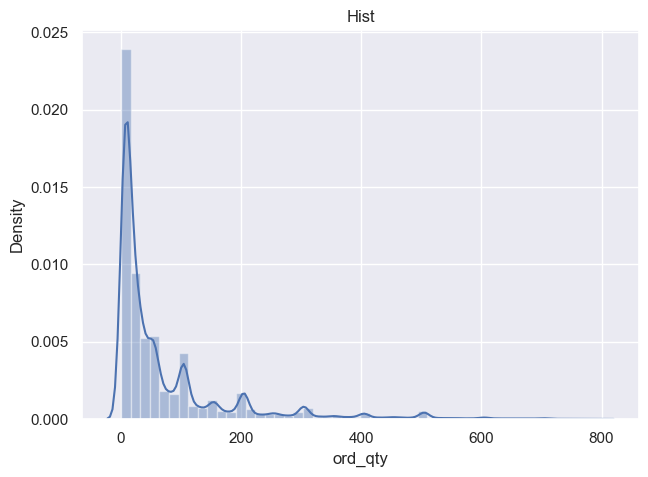


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.25506608228704275, pvalue=0.0)
变量极差	Max(797.000000)-Min(1.000000) = 796.000000
---频率分布情况---


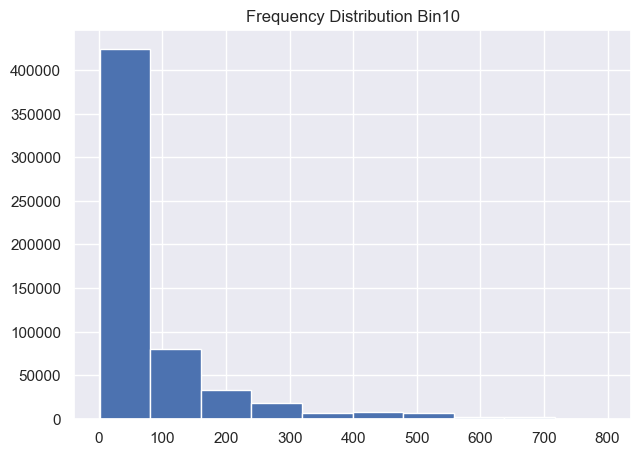

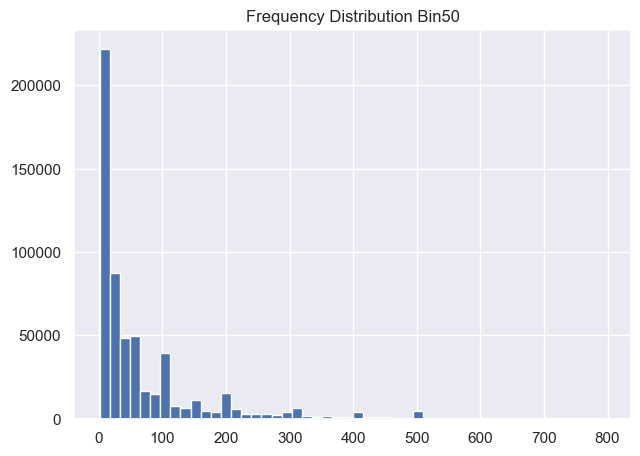

---分组区间---
0      [1.0, 80.6)
1      [1.0, 80.6)
2    [80.6, 160.2)
3      [1.0, 80.6)
4      [1.0, 80.6)
Name: ord_qty, dtype: category
Categories (10, interval[float64, left]): [[1.0, 80.6) < [80.6, 160.2) < [160.2, 239.8) < [239.8, 319.4) ... [478.6, 558.2) < [558.2, 637.8) < [637.8, 717.4) < [717.4, 797.796)] 
------
[1.0, 80.6)         424696
[80.6, 160.2)        80632
[160.2, 239.8)       33316
[239.8, 319.4)       18640
[319.4, 399.0)        6724
[399.0, 478.6)        7350
[478.6, 558.2)        7155
[558.2, 637.8)        2318
[637.8, 717.4)        1502
[717.4, 797.796)       281
Name: ord_qty, dtype: int64
0     19
1     12
2    109
3      3
4      3
Name: ord_qty, dtype: int64
---输出频*表---
                      频数        频率      累计频率     频率%    累计频率%
[1.0, 80.6)       424696  0.728949  0.728949  72.89%   72.89%
[80.6, 160.2)      80632  0.138397  0.867346  13.84%   86.73%
[160.2, 239.8)     33316  0.057184  0.924530   5.72%   92.45%
[239.8, 319.4)     18640  0.031994  0.956524  

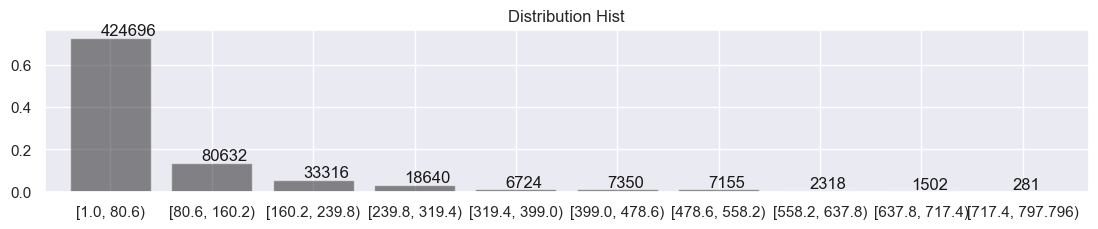

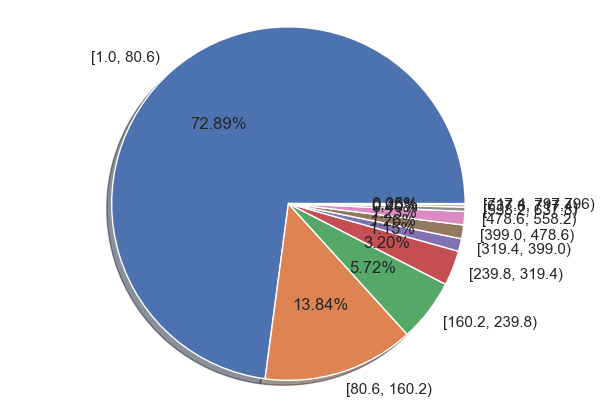

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0          19
1          12
2         109
3           3
4           3
         ... 
597689     59
597690    502
597691    106
597692    187
597693    205
Name: ord_qty, Length: 582614, dtype: int64


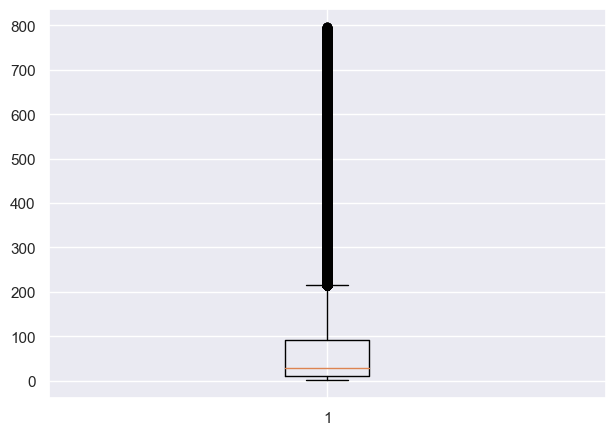




########################## Column dayofmonth##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---dayofmonth 描述性信息统计---
count    582614.000000
mean         16.901427
std           8.395453
min           1.000000
25%          10.000000
50%          17.000000
75%          24.000000
max          31.000000
Name: dayofmonth, dtype: float64


dayofmonth 列中的唯一值和数量如下：

26    22728
13    22406
25    22145
28    21983
27    21373
22    21317
14    21244
16    21109
11    21032
24    20937
23    20900
20    20605
12    20584
29    20250
8     20229
17    20058
10    19567
19    19552
9     19515
15    19213
18 

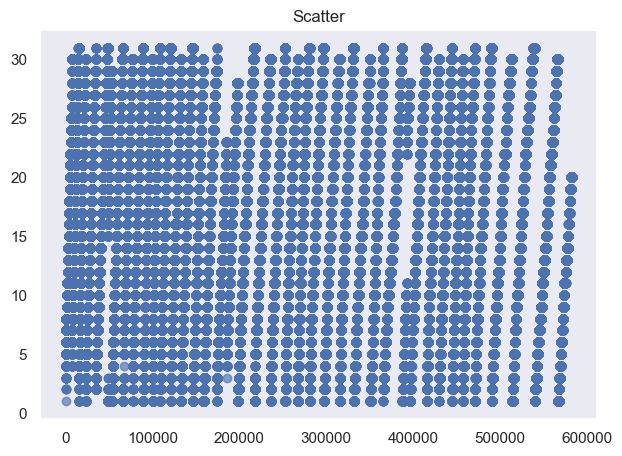

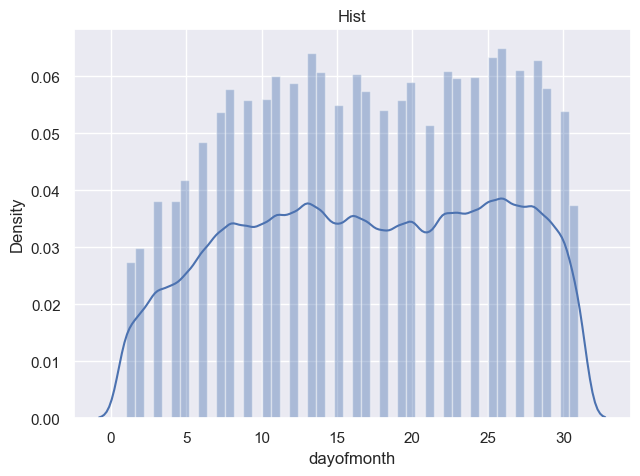


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.07903375784540045, pvalue=0.0)
变量极差	Max(31.000000)-Min(1.000000) = 30.000000
---频率分布情况---


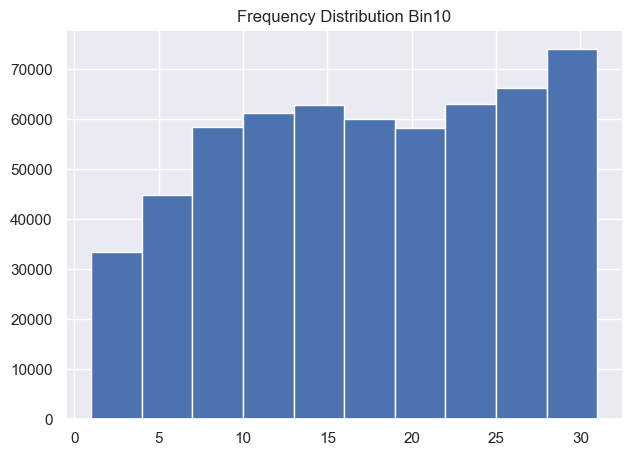

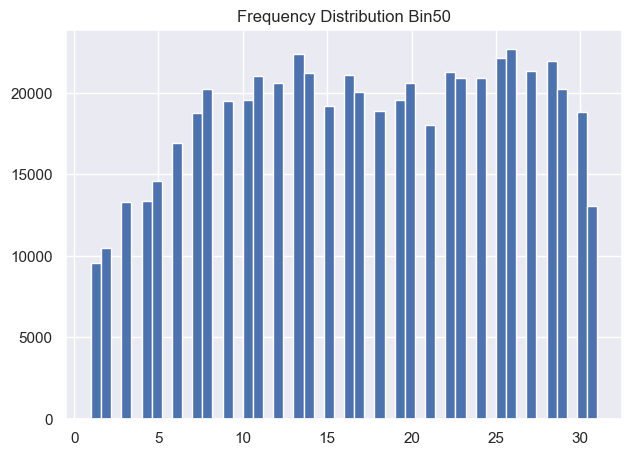

---分组区间---
0    [1.0, 4.0)
1    [1.0, 4.0)
2    [1.0, 4.0)
3    [1.0, 4.0)
4    [1.0, 4.0)
Name: dayofmonth, dtype: category
Categories (10, interval[float64, left]): [[1.0, 4.0) < [4.0, 7.0) < [7.0, 10.0) < [10.0, 13.0) ... [19.0, 22.0) < [22.0, 25.0) < [25.0, 28.0) < [28.0, 31.03)] 
------
[1.0, 4.0)       33359
[4.0, 7.0)       44863
[7.0, 10.0)      58529
[10.0, 13.0)     61183
[13.0, 16.0)     62863
[16.0, 19.0)     60067
[19.0, 22.0)     58176
[22.0, 25.0)     63154
[25.0, 28.0)     66246
[28.0, 31.03)    74174
Name: dayofmonth, dtype: int64
0    1
1    1
2    2
3    2
4    2
Name: dayofmonth, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[1.0, 4.0)     33359  0.057257  0.057257   5.73%    5.73%
[4.0, 7.0)     44863  0.077003  0.134260   7.70%   13.43%
[7.0, 10.0)    58529  0.100459  0.234720  10.05%   23.47%
[10.0, 13.0)   61183  0.105015  0.339734  10.50%   33.97%
[13.0, 16.0)   62863  0.107898  0.447633  10.79%   44.76%
[16.0, 19.0)   60067

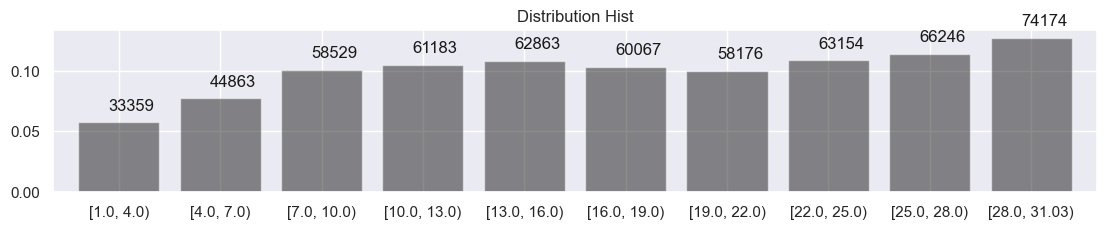

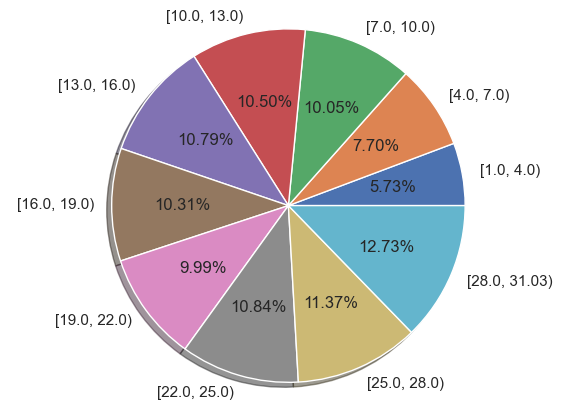

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0          1
1          1
2          2
3          2
4          2
          ..
597689    20
597690    20
597691    20
597692    20
597693    20
Name: dayofmonth, Length: 582614, dtype: int64


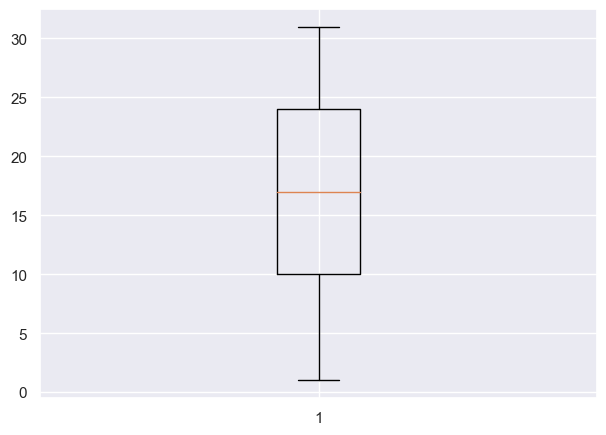




########################## Column dayofweek##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---dayofweek 描述性信息统计---
count    582614.000000
mean          2.970186
std           1.904737
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: dayofweek, dtype: float64


dayofweek 列中的唯一值和数量如下：

3    93755
4    91594
2    87084
1    87030
5    84181
0    72182
6    66788
Name: dayofweek, dtype: int64


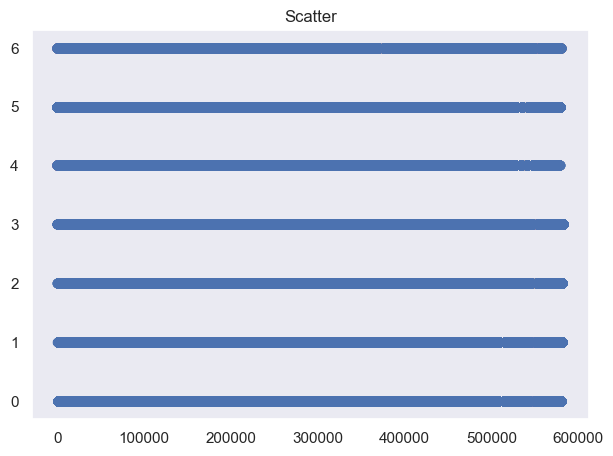

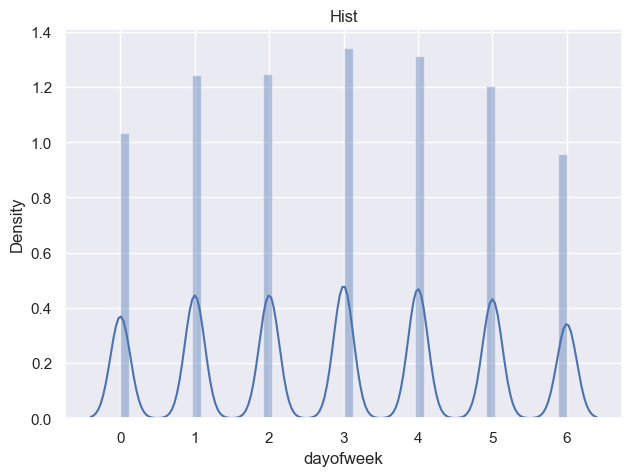


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.12278813503900432, pvalue=0.0)
变量极差	Max(6.000000)-Min(0.000000) = 6.000000
---频率分布情况---


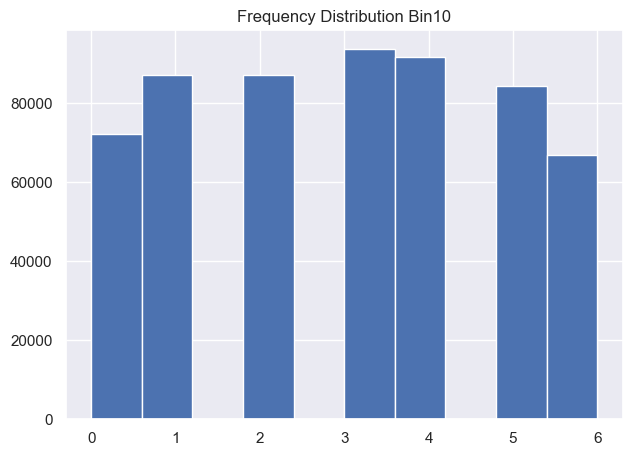

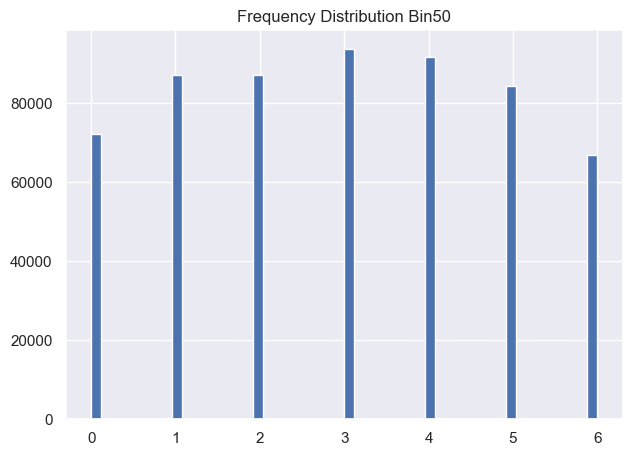

---分组区间---
0    [0.6, 1.2)
1    [0.6, 1.2)
2    [1.8, 2.4)
3    [1.8, 2.4)
4    [1.8, 2.4)
Name: dayofweek, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.6) < [0.6, 1.2) < [1.2, 1.8) < [1.8, 2.4) ... [3.6, 4.2) < [4.2, 4.8) < [4.8, 5.4) < [5.4, 6.006)] 
------
[0.0, 0.6)      72182
[0.6, 1.2)      87030
[1.2, 1.8)          0
[1.8, 2.4)      87084
[2.4, 3.0)          0
[3.0, 3.6)      93755
[3.6, 4.2)      91594
[4.2, 4.8)          0
[4.8, 5.4)      84181
[5.4, 6.006)    66788
Name: dayofweek, dtype: int64
0    1
1    1
2    2
3    2
4    2
Name: dayofweek, dtype: int64
---输出频*表---
                 频数        频率      累计频率     频率%    累计频率%
[0.0, 0.6)    72182  0.123893  0.123893  12.39%   12.39%
[0.6, 1.2)    87030  0.149378  0.273272  14.94%   27.33%
[1.2, 1.8)        0  0.000000  0.273272   0.00%   27.33%
[1.8, 2.4)    87084  0.149471  0.422743  14.95%   42.27%
[2.4, 3.0)        0  0.000000  0.422743   0.00%   42.27%
[3.0, 3.6)    93755  0.160921  0.583664  16.09%  

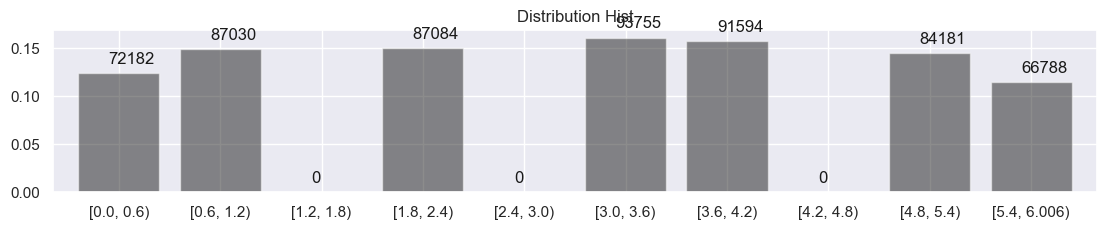

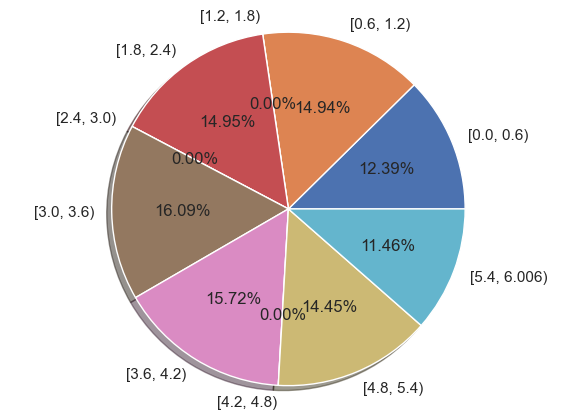

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         1
1         1
2         2
3         2
4         2
         ..
597689    3
597690    3
597691    3
597692    3
597693    3
Name: dayofweek, Length: 582614, dtype: int64


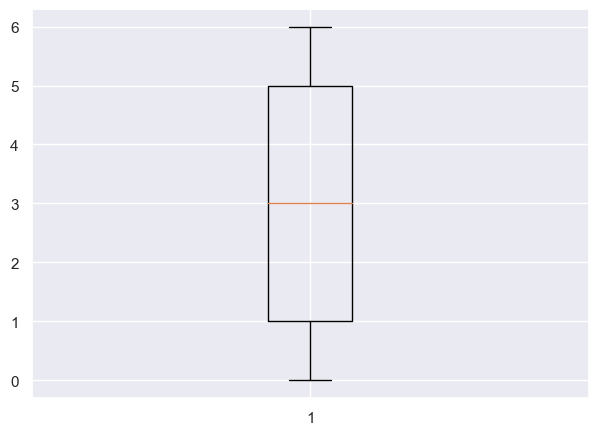




########################## Column month##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---month 描述性信息统计---
count    582614.000000
mean          7.061260
std           3.500812
min           1.000000
25%           4.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


month 列中的唯一值和数量如下：

11    65848
10    63588
9     61086
12    57666
3     51484
8     47849
1     47070
5     44300
4     43930
6     37095
7     36503
2     26195
Name: month, dtype: int64


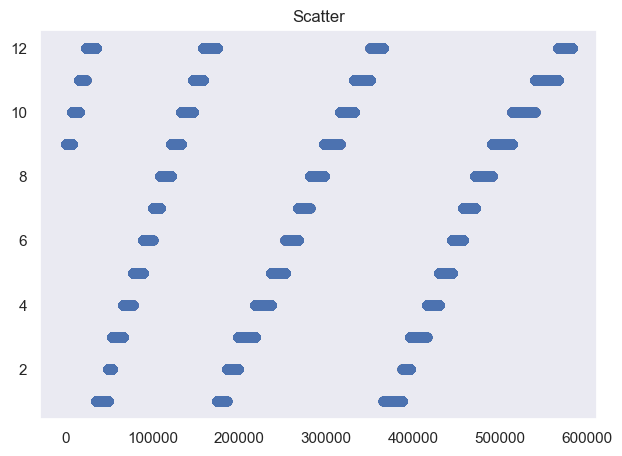

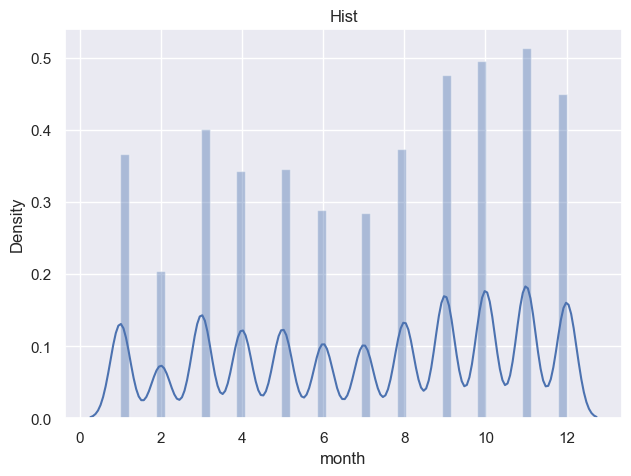


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.13613163633355752, pvalue=0.0)
变量极差	Max(12.000000)-Min(1.000000) = 11.000000
---频率分布情况---


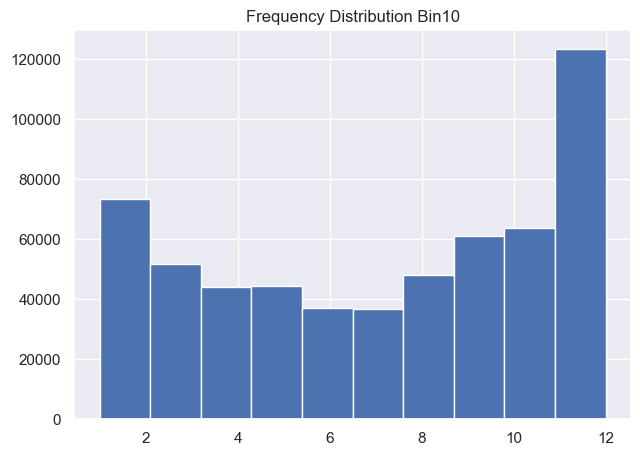

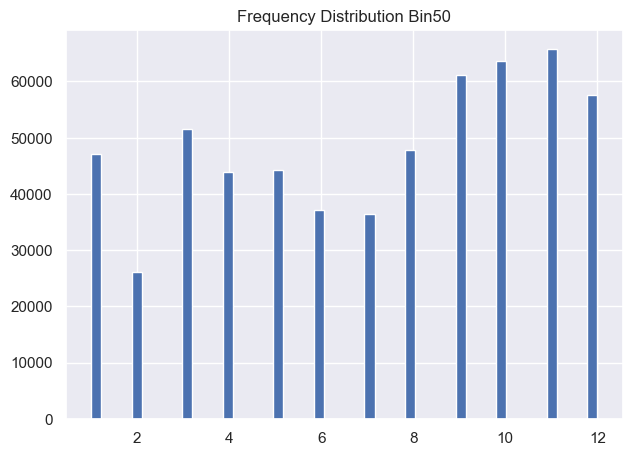

---分组区间---
0    [8.7, 9.8)
1    [8.7, 9.8)
2    [8.7, 9.8)
3    [8.7, 9.8)
4    [8.7, 9.8)
Name: month, dtype: category
Categories (10, interval[float64, left]): [[1.0, 2.1) < [2.1, 3.2) < [3.2, 4.3) < [4.3, 5.4) ... [7.6, 8.7) < [8.7, 9.8) < [9.8, 10.9) < [10.9, 12.011)] 
------
[1.0, 2.1)         73265
[2.1, 3.2)         51484
[3.2, 4.3)         43930
[4.3, 5.4)         44300
[5.4, 6.5)         37095
[6.5, 7.6)         36503
[7.6, 8.7)         47849
[8.7, 9.8)         61086
[9.8, 10.9)        63588
[10.9, 12.011)    123514
Name: month, dtype: int64
0    9
1    9
2    9
3    9
4    9
Name: month, dtype: int64
---输出频*表---
                    频数        频率      累计频率     频率%    累计频率%
[1.0, 2.1)       73265  0.125752  0.125752  12.58%   12.58%
[2.1, 3.2)       51484  0.088367  0.214119   8.84%   21.41%
[3.2, 4.3)       43930  0.075402  0.289521   7.54%   28.95%
[4.3, 5.4)       44300  0.076037  0.365558   7.60%   36.56%
[5.4, 6.5)       37095  0.063670  0.429228   6.37%   42.92%
[6.5, 7.6)

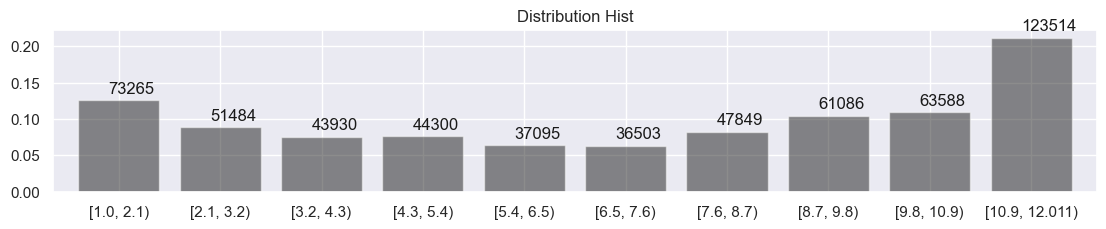

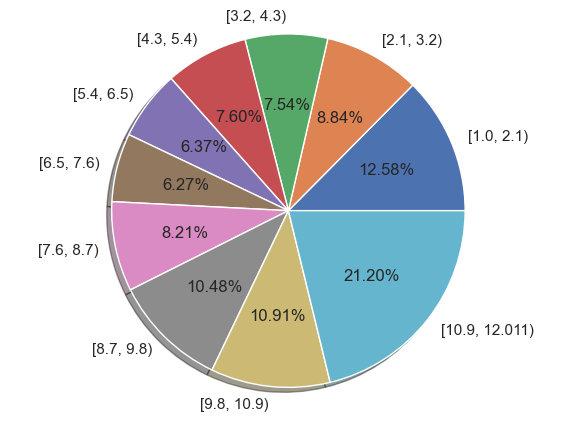

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0          9
1          9
2          9
3          9
4          9
          ..
597689    12
597690    12
597691    12
597692    12
597693    12
Name: month, Length: 582614, dtype: int64


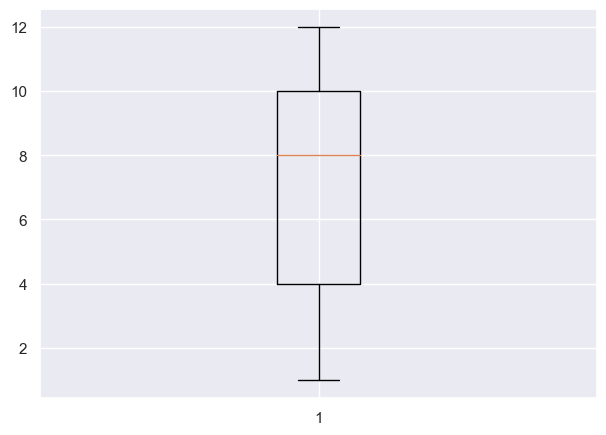




########################## Column year##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---year 描述性信息统计---
count    582614.000000
mean       2017.013136
std           0.921691
min        2015.000000
25%        2016.000000
50%        2017.000000
75%        2018.000000
max        2018.000000
Name: year, dtype: float64


year 列中的唯一值和数量如下：

2018    216633
2017    191714
2016    139554
2015     34713
Name: year, dtype: int64


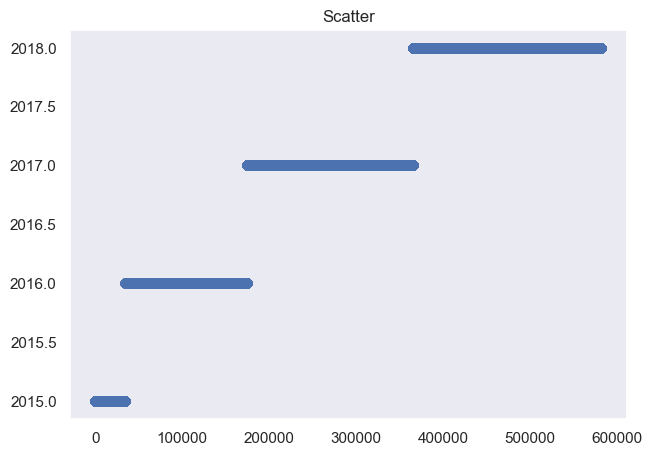

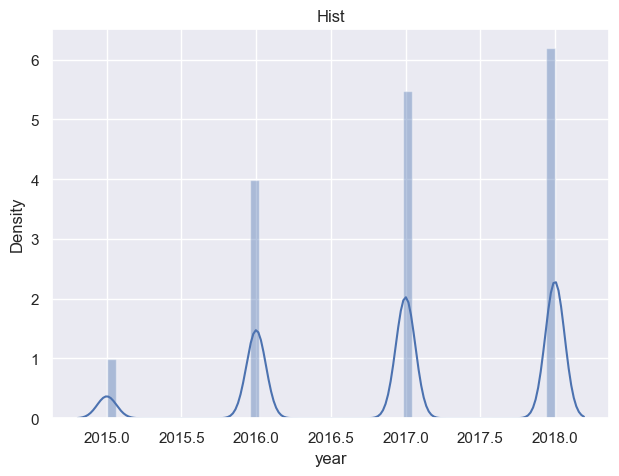


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.2296795035115693, pvalue=0.0)
变量极差	Max(2018.000000)-Min(2015.000000) = 3.000000
---频率分布情况---


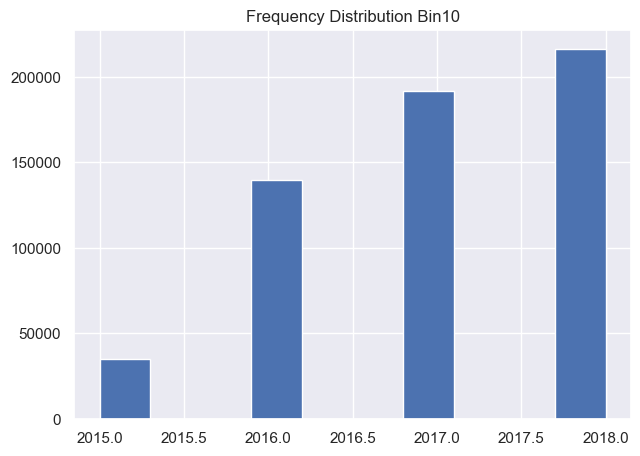

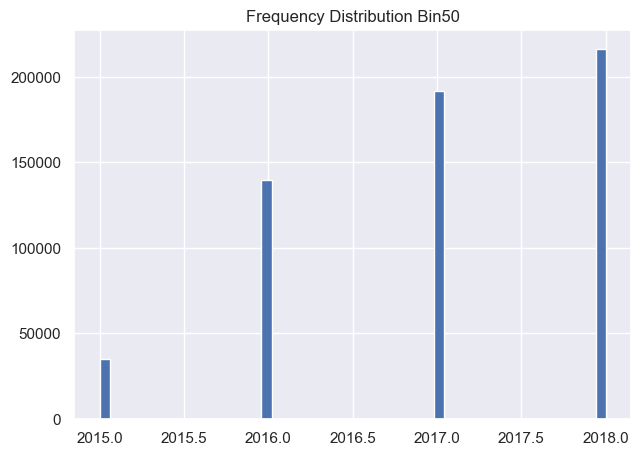

---分组区间---
0    [2015.0, 2015.3)
1    [2015.0, 2015.3)
2    [2015.0, 2015.3)
3    [2015.0, 2015.3)
4    [2015.0, 2015.3)
Name: year, dtype: category
Categories (10, interval[float64, left]): [[2015.0, 2015.3) < [2015.3, 2015.6) < [2015.6, 2015.9) < [2015.9, 2016.2) ... [2016.8, 2017.1) < [2017.1, 2017.4) < [2017.4, 2017.7) < [2017.7, 2018.003)] 
------
[2015.0, 2015.3)       34713
[2015.3, 2015.6)           0
[2015.6, 2015.9)           0
[2015.9, 2016.2)      139554
[2016.2, 2016.5)           0
[2016.5, 2016.8)           0
[2016.8, 2017.1)      191714
[2017.1, 2017.4)           0
[2017.4, 2017.7)           0
[2017.7, 2018.003)    216633
Name: year, dtype: int64
0    2015
1    2015
2    2015
3    2015
4    2015
Name: year, dtype: int64
---输出频*表---
                        频数        频率      累计频率     频率%    累计频率%
[2015.0, 2015.3)     34713  0.059581  0.059581   5.96%    5.96%
[2015.3, 2015.6)         0  0.000000  0.059581   0.00%    5.96%
[2015.6, 2015.9)         0  0.000000  0.059581   0.

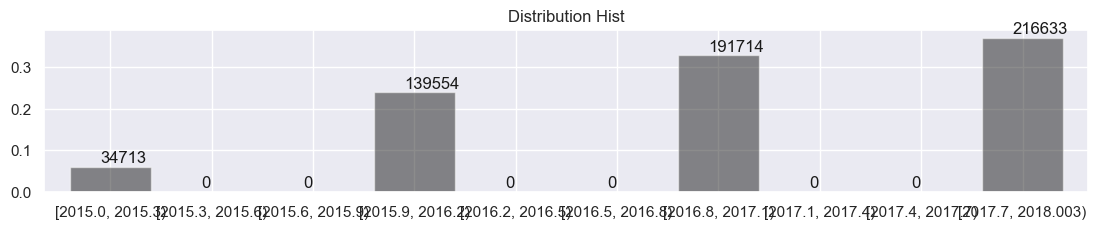

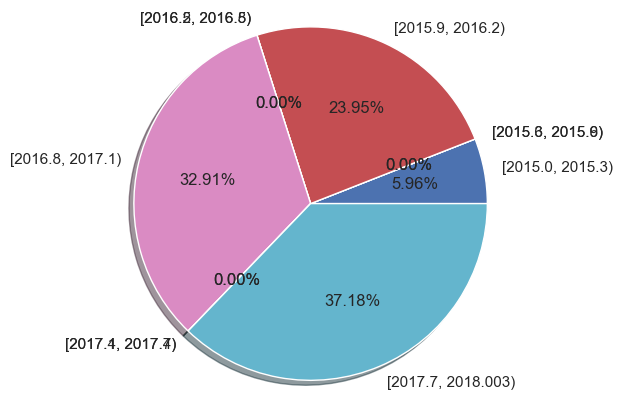

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         2015
1         2015
2         2015
3         2015
4         2015
          ... 
597689    2018
597690    2018
597691    2018
597692    2018
597693    2018
Name: year, Length: 582614, dtype: int64


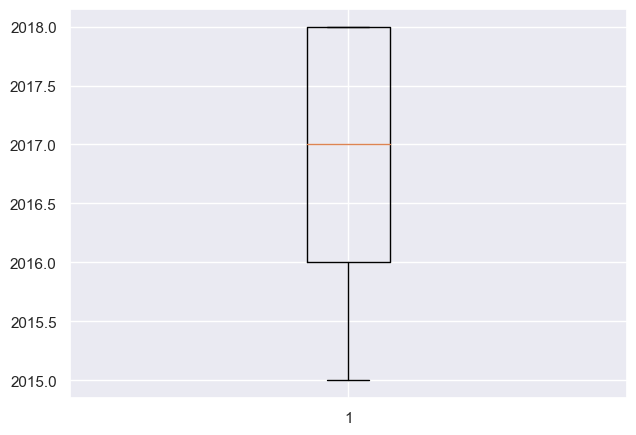




########################## Column is_month_start##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---is_month_start 描述性信息统计---
count    582614.000000
mean          0.016438
std           0.127153
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_month_start, dtype: float64


is_month_start 列中的唯一值和数量如下：

0    573037
1      9577
Name: is_month_start, dtype: int64


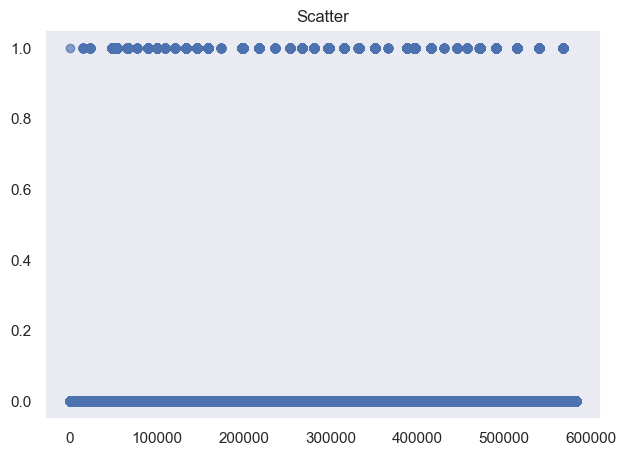

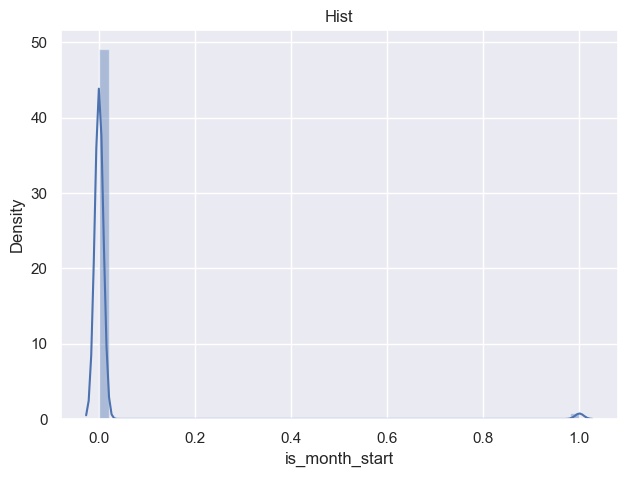


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.534992989158481, pvalue=0.0)
变量极差	Max(1.000000)-Min(0.000000) = 1.000000
---频率分布情况---


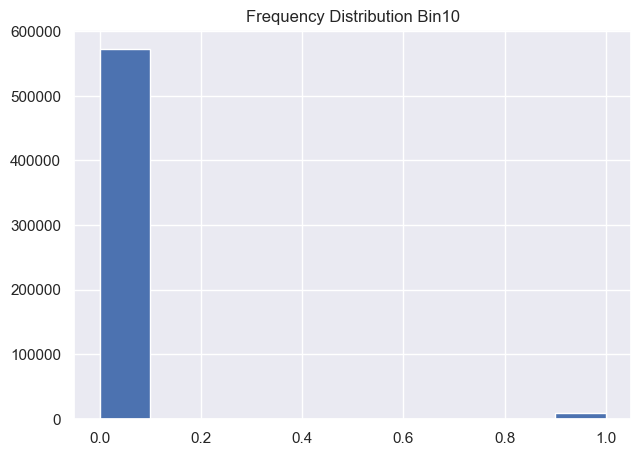

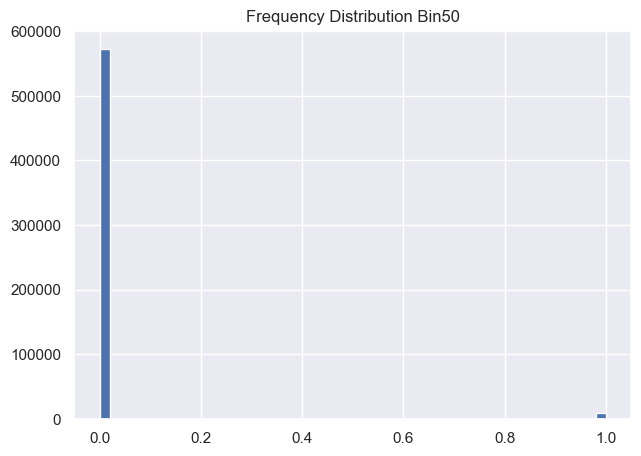

---分组区间---
0    [0.9, 1.001)
1    [0.9, 1.001)
2      [0.0, 0.1)
3      [0.0, 0.1)
4      [0.0, 0.1)
Name: is_month_start, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.1) < [0.1, 0.2) < [0.2, 0.3) < [0.3, 0.4) ... [0.6, 0.7) < [0.7, 0.8) < [0.8, 0.9) < [0.9, 1.001)] 
------
[0.0, 0.1)      573037
[0.1, 0.2)           0
[0.2, 0.3)           0
[0.3, 0.4)           0
[0.4, 0.5)           0
[0.5, 0.6)           0
[0.6, 0.7)           0
[0.7, 0.8)           0
[0.8, 0.9)           0
[0.9, 1.001)      9577
Name: is_month_start, dtype: int64
0    1
1    1
2    0
3    0
4    0
Name: is_month_start, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[0.0, 0.1)    573037  0.983562  0.983562  98.36%   98.36%
[0.1, 0.2)         0  0.000000  0.983562   0.00%   98.36%
[0.2, 0.3)         0  0.000000  0.983562   0.00%   98.36%
[0.3, 0.4)         0  0.000000  0.983562   0.00%   98.36%
[0.4, 0.5)         0  0.000000  0.983562   0.00%   98.36%
[0.5, 0.

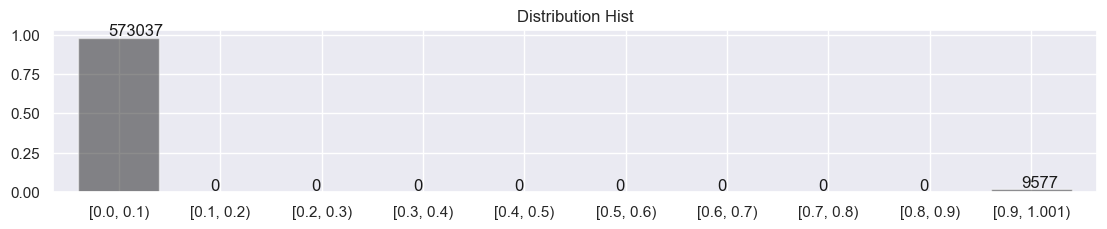

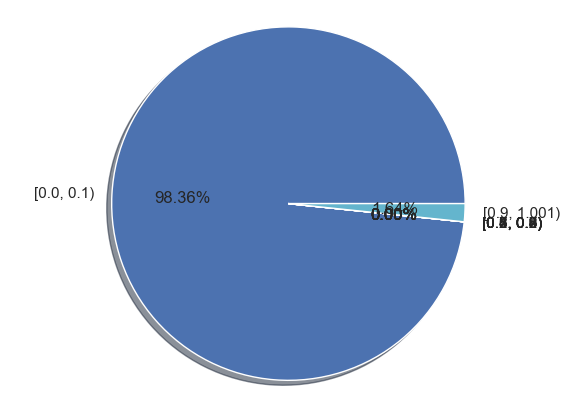

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         1
1         1
2         0
3         0
4         0
         ..
597689    0
597690    0
597691    0
597692    0
597693    0
Name: is_month_start, Length: 582614, dtype: int64


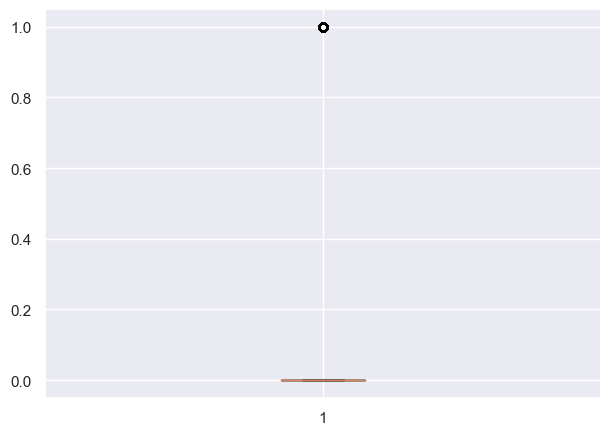




########################## Column is_month_end##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---is_month_end 描述性信息统计---
count    582614.000000
mean          0.038827
std           0.193182
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_month_end, dtype: float64


is_month_end 列中的唯一值和数量如下：

0    559993
1     22621
Name: is_month_end, dtype: int64


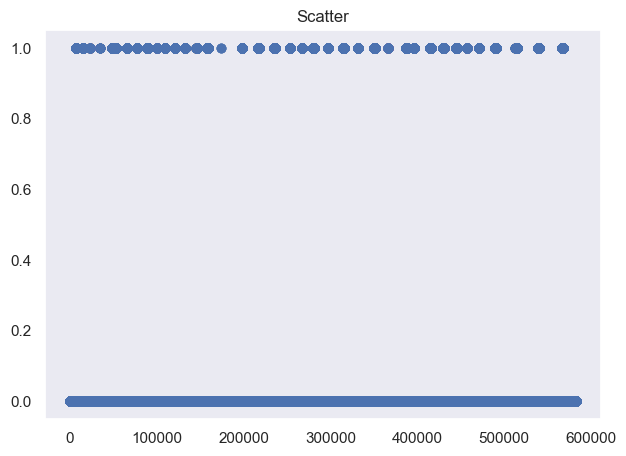

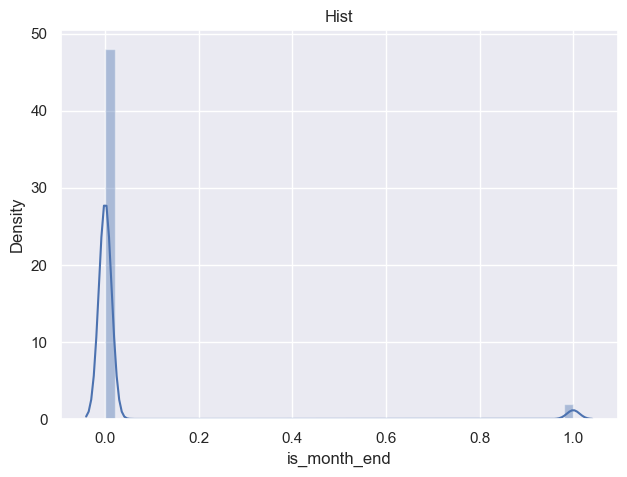


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.5408182177117955, pvalue=0.0)
变量极差	Max(1.000000)-Min(0.000000) = 1.000000
---频率分布情况---


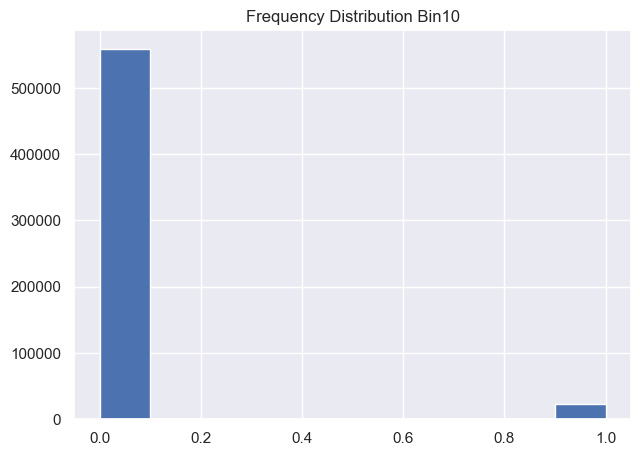

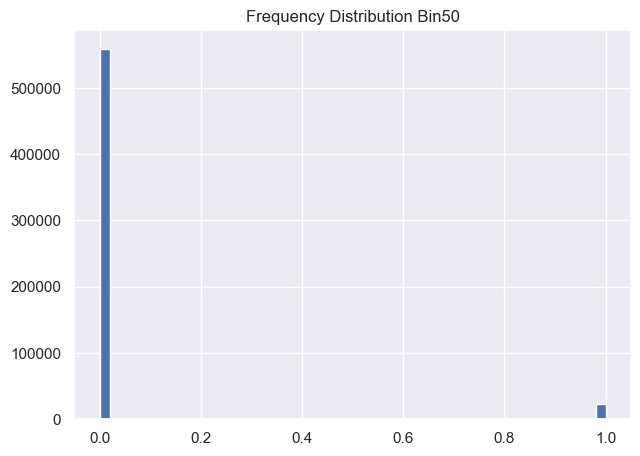

---分组区间---
0    [0.0, 0.1)
1    [0.0, 0.1)
2    [0.0, 0.1)
3    [0.0, 0.1)
4    [0.0, 0.1)
Name: is_month_end, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.1) < [0.1, 0.2) < [0.2, 0.3) < [0.3, 0.4) ... [0.6, 0.7) < [0.7, 0.8) < [0.8, 0.9) < [0.9, 1.001)] 
------
[0.0, 0.1)      559993
[0.1, 0.2)           0
[0.2, 0.3)           0
[0.3, 0.4)           0
[0.4, 0.5)           0
[0.5, 0.6)           0
[0.6, 0.7)           0
[0.7, 0.8)           0
[0.8, 0.9)           0
[0.9, 1.001)     22621
Name: is_month_end, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: is_month_end, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[0.0, 0.1)    559993  0.961173  0.961173  96.12%   96.12%
[0.1, 0.2)         0  0.000000  0.961173   0.00%   96.12%
[0.2, 0.3)         0  0.000000  0.961173   0.00%   96.12%
[0.3, 0.4)         0  0.000000  0.961173   0.00%   96.12%
[0.4, 0.5)         0  0.000000  0.961173   0.00%   96.12%
[0.5, 0.6)         0  0.

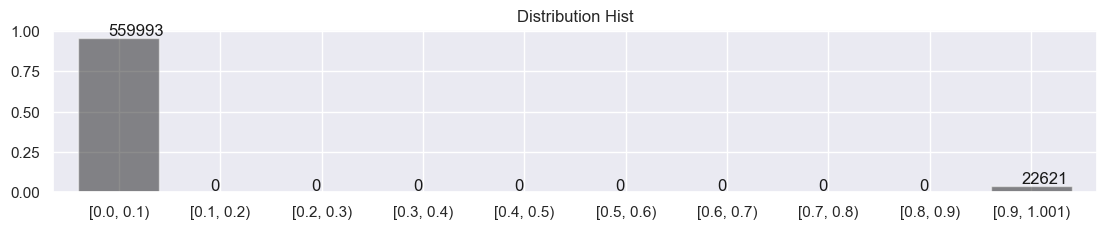

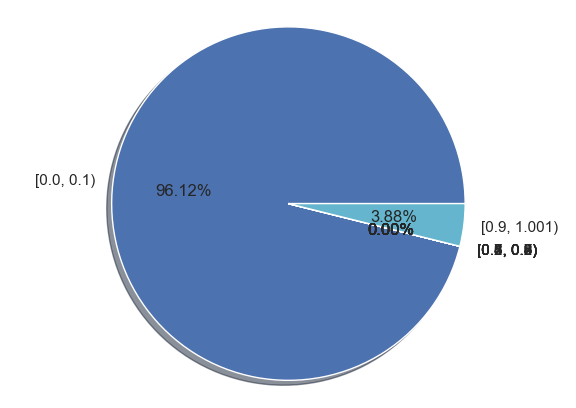

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         0
1         0
2         0
3         0
4         0
         ..
597689    0
597690    0
597691    0
597692    0
597693    0
Name: is_month_end, Length: 582614, dtype: int64


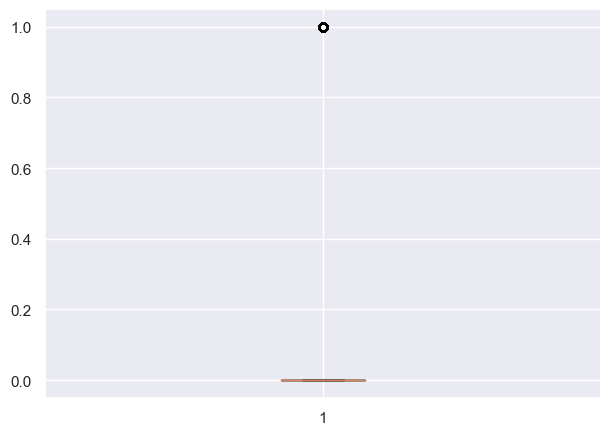




########################## Column is_workday##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---is_workday 描述性信息统计---
count    582614.000000
mean          0.737694
std           0.439888
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_workday, dtype: float64


is_workday 列中的唯一值和数量如下：

1    429791
0    152823
Name: is_workday, dtype: int64


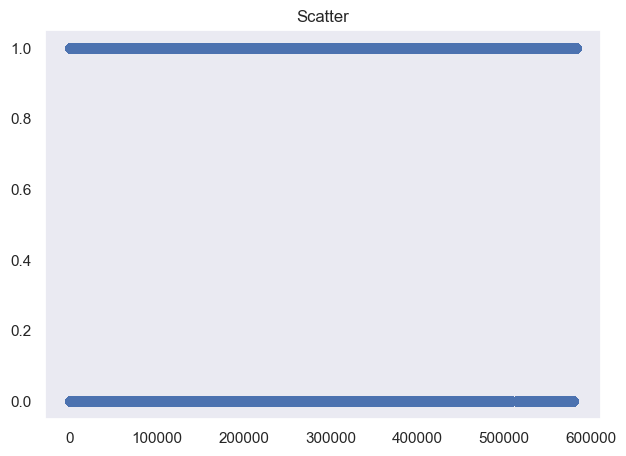

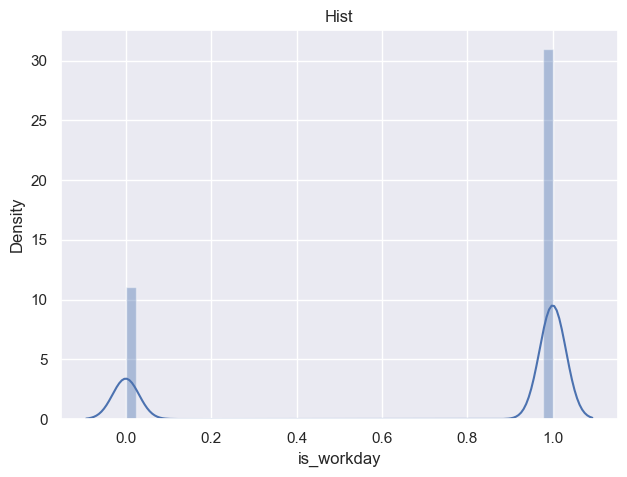


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.46220707669683575, pvalue=0.0)
变量极差	Max(1.000000)-Min(0.000000) = 1.000000
---频率分布情况---


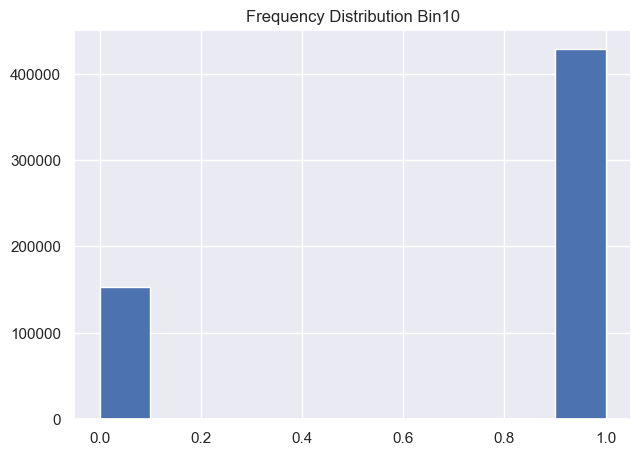

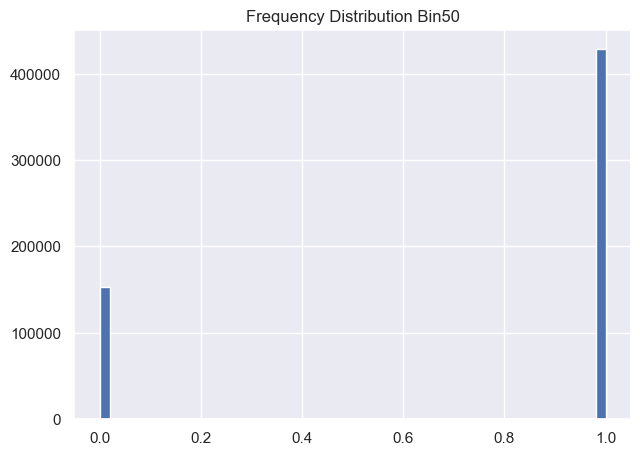

---分组区间---
0    [0.9, 1.001)
1    [0.9, 1.001)
2    [0.9, 1.001)
3    [0.9, 1.001)
4    [0.9, 1.001)
Name: is_workday, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.1) < [0.1, 0.2) < [0.2, 0.3) < [0.3, 0.4) ... [0.6, 0.7) < [0.7, 0.8) < [0.8, 0.9) < [0.9, 1.001)] 
------
[0.0, 0.1)      152823
[0.1, 0.2)           0
[0.2, 0.3)           0
[0.3, 0.4)           0
[0.4, 0.5)           0
[0.5, 0.6)           0
[0.6, 0.7)           0
[0.7, 0.8)           0
[0.8, 0.9)           0
[0.9, 1.001)    429791
Name: is_workday, dtype: int64
0    1
1    1
2    1
3    1
4    1
Name: is_workday, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[0.0, 0.1)    152823  0.262306  0.262306  26.23%   26.23%
[0.1, 0.2)         0  0.000000  0.262306   0.00%   26.23%
[0.2, 0.3)         0  0.000000  0.262306   0.00%   26.23%
[0.3, 0.4)         0  0.000000  0.262306   0.00%   26.23%
[0.4, 0.5)         0  0.000000  0.262306   0.00%   26.23%
[0.5, 0.6)         0

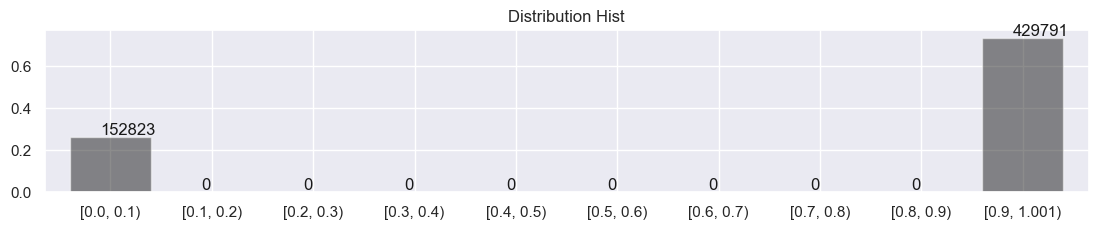

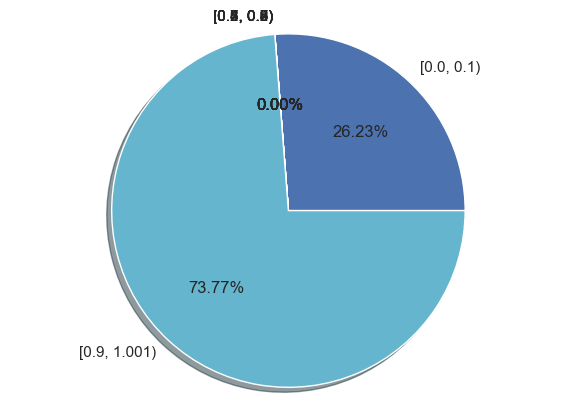

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         1
1         1
2         1
3         1
4         1
         ..
597689    1
597690    1
597691    1
597692    1
597693    1
Name: is_workday, Length: 582614, dtype: int64


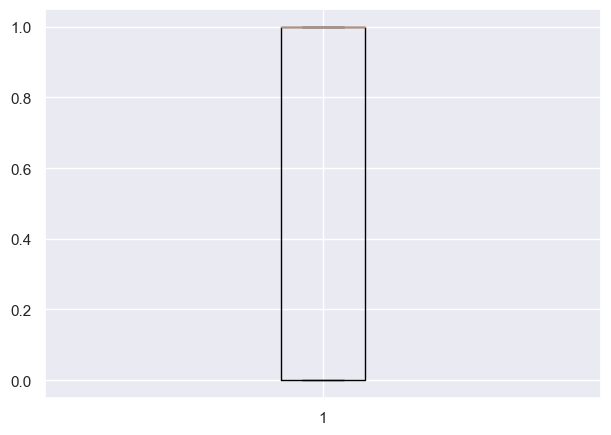




########################## Column is_holiday##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---is_holiday 描述性信息统计---
count    582614.000000
mean          0.262306
std           0.439888
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_holiday, dtype: float64


is_holiday 列中的唯一值和数量如下：

0    429791
1    152823
Name: is_holiday, dtype: int64


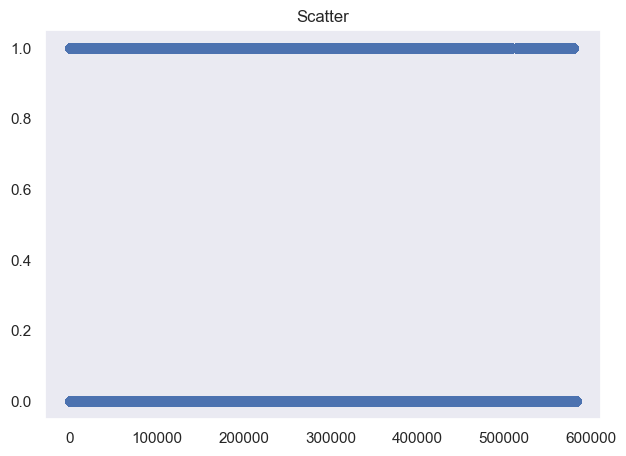

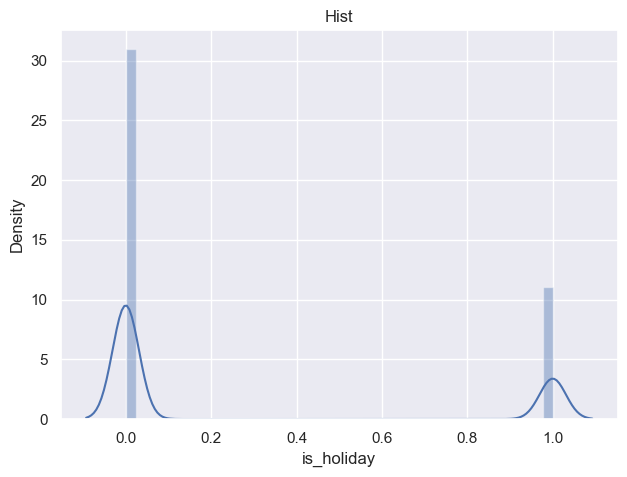


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.4622070766968358, pvalue=0.0)
变量极差	Max(1.000000)-Min(0.000000) = 1.000000
---频率分布情况---


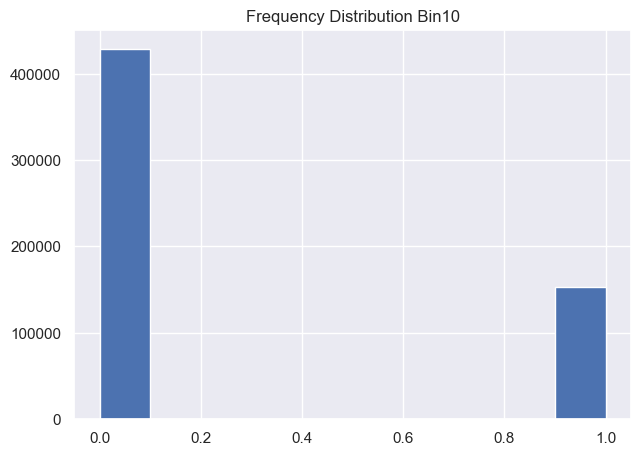

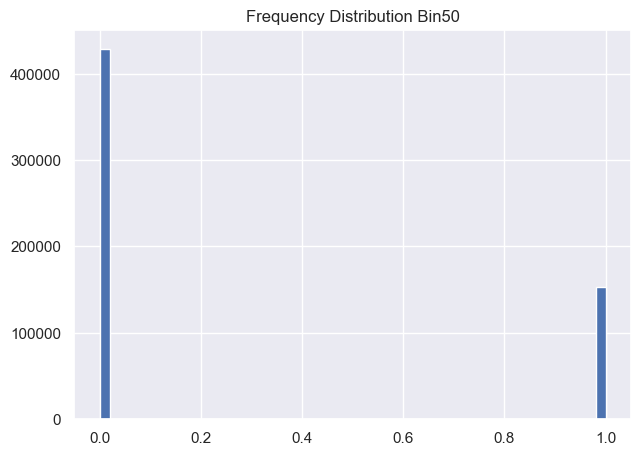

---分组区间---
0    [0.0, 0.1)
1    [0.0, 0.1)
2    [0.0, 0.1)
3    [0.0, 0.1)
4    [0.0, 0.1)
Name: is_holiday, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.1) < [0.1, 0.2) < [0.2, 0.3) < [0.3, 0.4) ... [0.6, 0.7) < [0.7, 0.8) < [0.8, 0.9) < [0.9, 1.001)] 
------
[0.0, 0.1)      429791
[0.1, 0.2)           0
[0.2, 0.3)           0
[0.3, 0.4)           0
[0.4, 0.5)           0
[0.5, 0.6)           0
[0.6, 0.7)           0
[0.7, 0.8)           0
[0.8, 0.9)           0
[0.9, 1.001)    152823
Name: is_holiday, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: is_holiday, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[0.0, 0.1)    429791  0.737694  0.737694  73.77%   73.77%
[0.1, 0.2)         0  0.000000  0.737694   0.00%   73.77%
[0.2, 0.3)         0  0.000000  0.737694   0.00%   73.77%
[0.3, 0.4)         0  0.000000  0.737694   0.00%   73.77%
[0.4, 0.5)         0  0.000000  0.737694   0.00%   73.77%
[0.5, 0.6)         0  0.000000

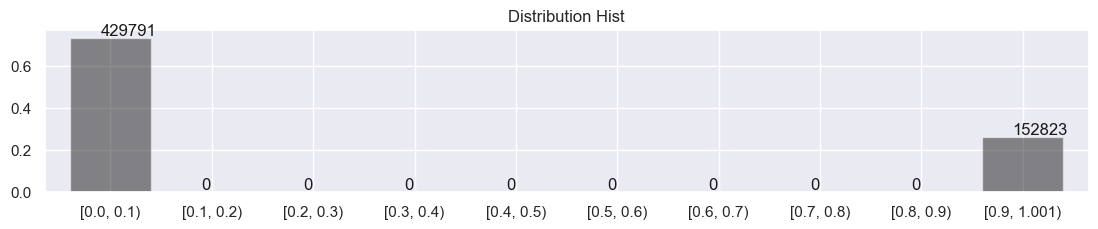

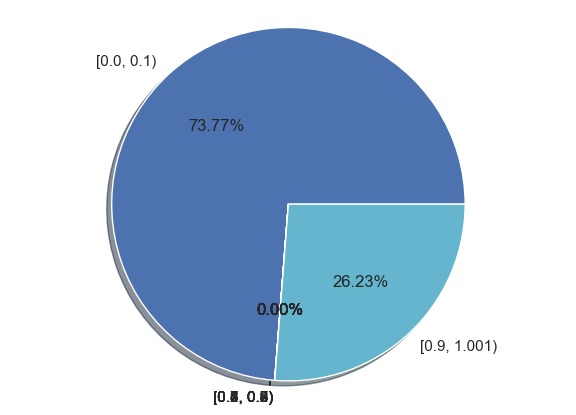

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         0
1         0
2         0
3         0
4         0
         ..
597689    0
597690    0
597691    0
597692    0
597693    0
Name: is_holiday, Length: 582614, dtype: int64


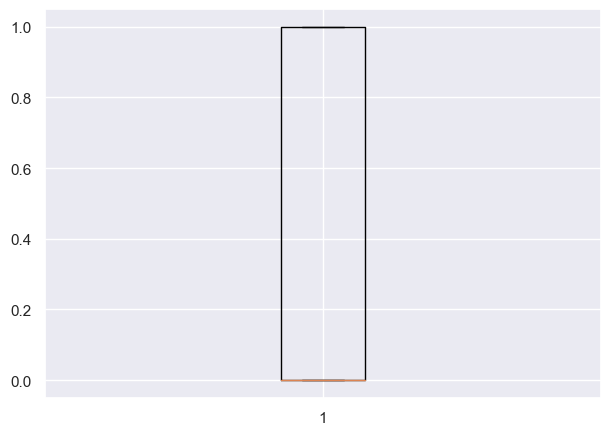




########################## Column in_quarter##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---in_quarter 描述性信息统计---
count    582614.000000
mean          2.677795
std           1.135304
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: in_quarter, dtype: float64


in_quarter 列中的唯一值和数量如下：

4    187102
3    145438
2    125325
1    124749
Name: in_quarter, dtype: int64


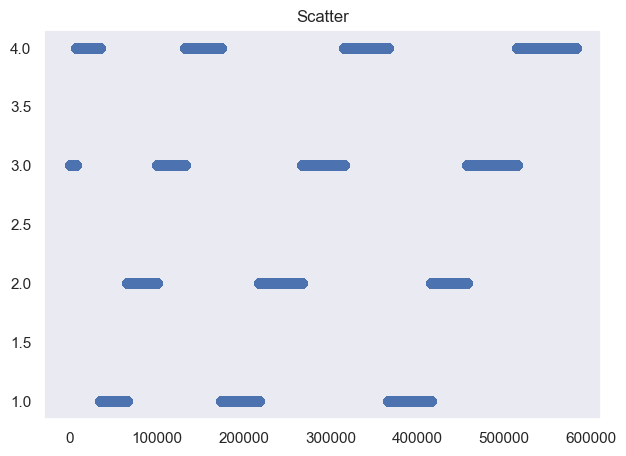

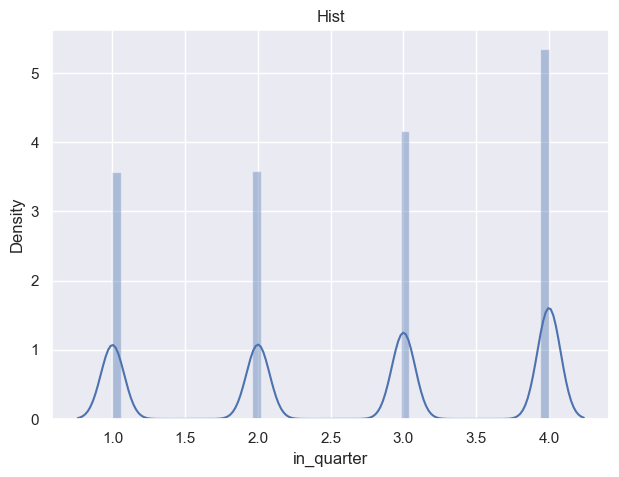


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.19905718019486518, pvalue=0.0)
变量极差	Max(4.000000)-Min(1.000000) = 3.000000
---频率分布情况---


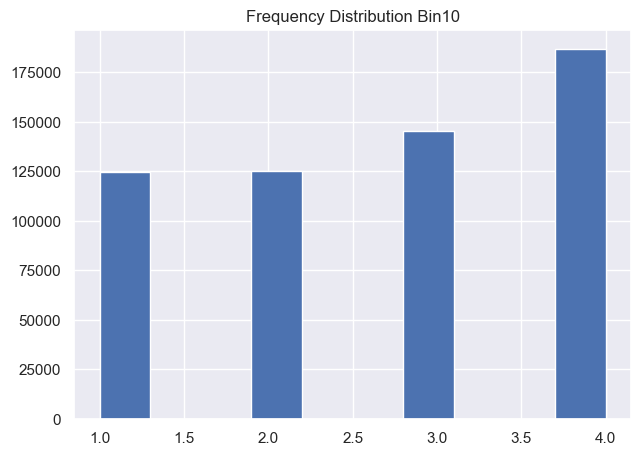

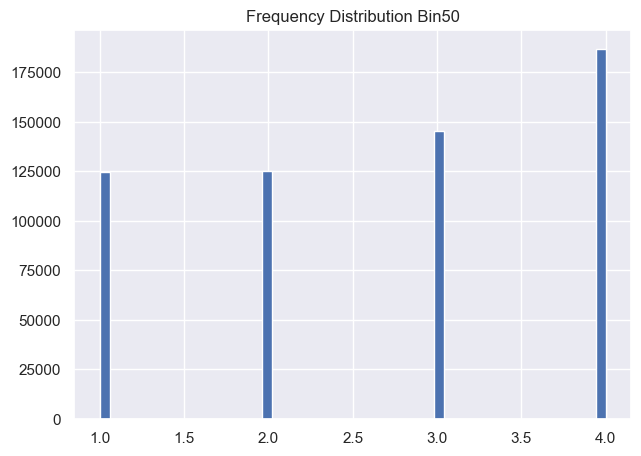

---分组区间---
0    [2.8, 3.1)
1    [2.8, 3.1)
2    [2.8, 3.1)
3    [2.8, 3.1)
4    [2.8, 3.1)
Name: in_quarter, dtype: category
Categories (10, interval[float64, left]): [[1.0, 1.3) < [1.3, 1.6) < [1.6, 1.9) < [1.9, 2.2) ... [2.8, 3.1) < [3.1, 3.4) < [3.4, 3.7) < [3.7, 4.003)] 
------
[1.0, 1.3)      124749
[1.3, 1.6)           0
[1.6, 1.9)           0
[1.9, 2.2)      125325
[2.2, 2.5)           0
[2.5, 2.8)           0
[2.8, 3.1)      145438
[3.1, 3.4)           0
[3.4, 3.7)           0
[3.7, 4.003)    187102
Name: in_quarter, dtype: int64
0    3
1    3
2    3
3    3
4    3
Name: in_quarter, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[1.0, 1.3)    124749  0.214119  0.214119  21.41%   21.41%
[1.3, 1.6)         0  0.000000  0.214119   0.00%   21.41%
[1.6, 1.9)         0  0.000000  0.214119   0.00%   21.41%
[1.9, 2.2)    125325  0.215108  0.429228  21.51%   42.92%
[2.2, 2.5)         0  0.000000  0.429228   0.00%   42.92%
[2.5, 2.8)         0  0.000000

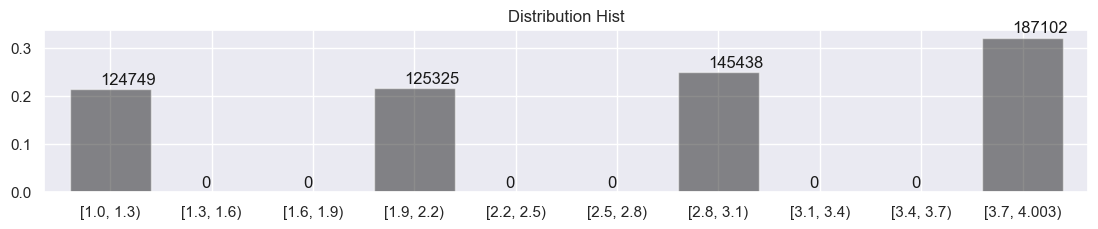

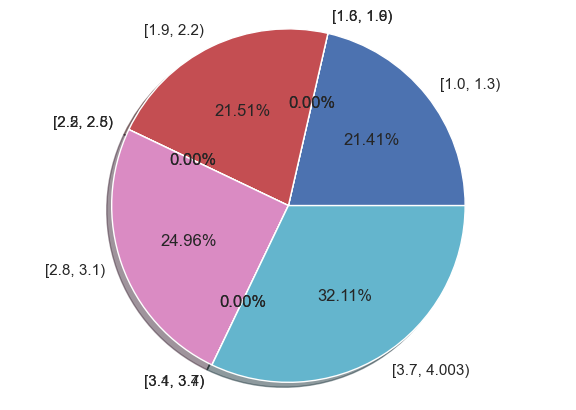

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         3
1         3
2         3
3         3
4         3
         ..
597689    4
597690    4
597691    4
597692    4
597693    4
Name: in_quarter, Length: 582614, dtype: int64


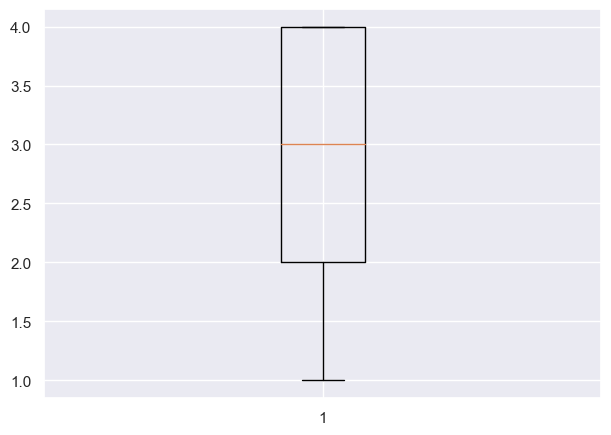




########################## Column in_month_stage##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---in_month_stage 描述性信息统计---
count    582614.000000
mean          1.112038
std           0.797556
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: in_month_stage, dtype: float64


in_month_stage 列中的唯一值和数量如下：

2    221593
1    204703
0    156318
Name: in_month_stage, dtype: int64


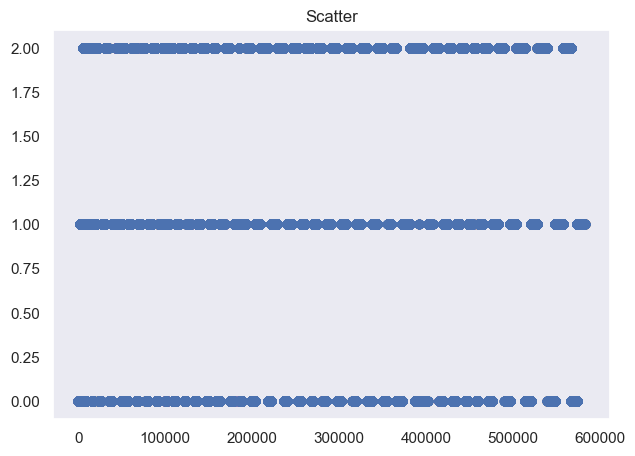

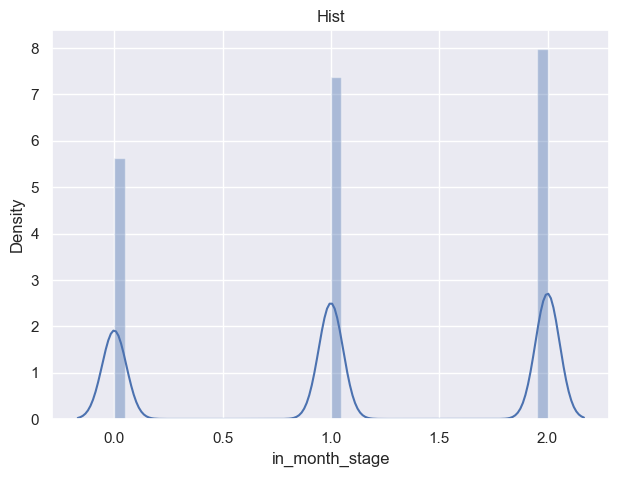


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.24756438186722862, pvalue=0.0)
变量极差	Max(2.000000)-Min(0.000000) = 2.000000
---频率分布情况---


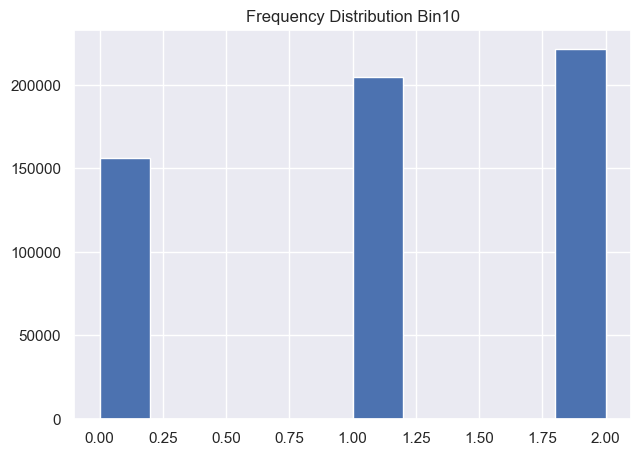

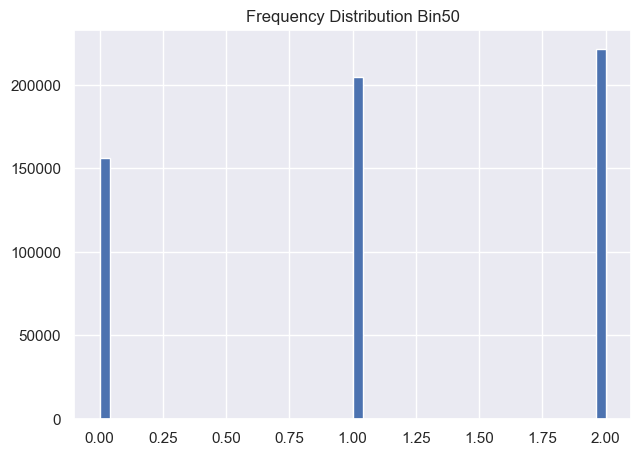

---分组区间---
0    [0.0, 0.2)
1    [0.0, 0.2)
2    [0.0, 0.2)
3    [0.0, 0.2)
4    [0.0, 0.2)
Name: in_month_stage, dtype: category
Categories (10, interval[float64, left]): [[0.0, 0.2) < [0.2, 0.4) < [0.4, 0.6) < [0.6, 0.8) ... [1.2, 1.4) < [1.4, 1.6) < [1.6, 1.8) < [1.8, 2.002)] 
------
[0.0, 0.2)      156318
[0.2, 0.4)           0
[0.4, 0.6)           0
[0.6, 0.8)           0
[0.8, 1.0)           0
[1.0, 1.2)      204703
[1.2, 1.4)           0
[1.4, 1.6)           0
[1.6, 1.8)           0
[1.8, 2.002)    221593
Name: in_month_stage, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: in_month_stage, dtype: int64
---输出频*表---
                  频数        频率      累计频率     频率%    累计频率%
[0.0, 0.2)    156318  0.268305  0.268305  26.83%   26.83%
[0.2, 0.4)         0  0.000000  0.268305   0.00%   26.83%
[0.4, 0.6)         0  0.000000  0.268305   0.00%   26.83%
[0.6, 0.8)         0  0.000000  0.268305   0.00%   26.83%
[0.8, 1.0)         0  0.000000  0.268305   0.00%   26.83%
[1.0, 1.2)    2047

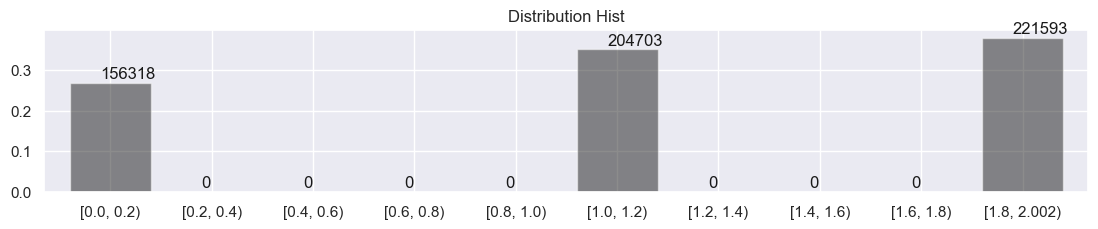

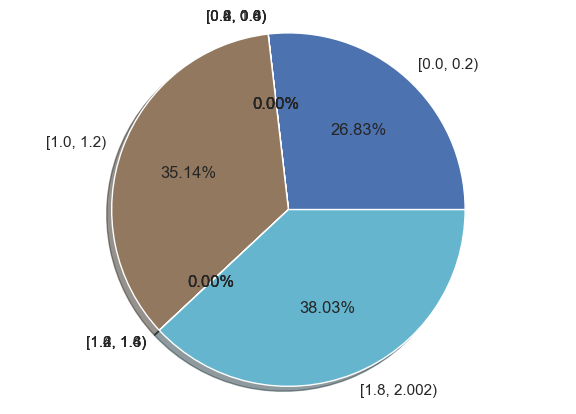

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0         0
1         0
2         0
3         0
4         0
         ..
597689    1
597690    1
597691    1
597692    1
597693    1
Name: in_month_stage, Length: 582614, dtype: int64


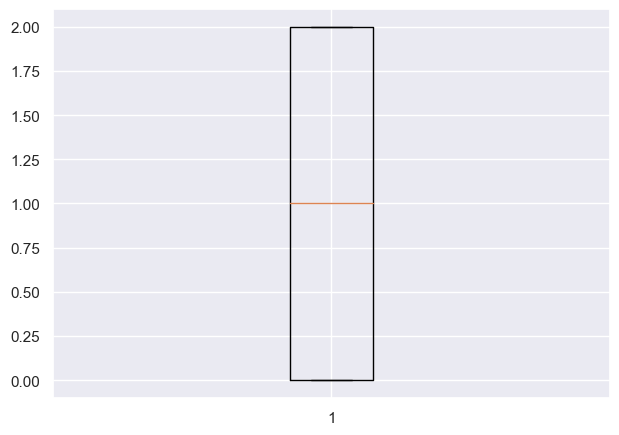




########################## Column month_num##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---month_num 描述性信息统计---
count    582614.000000
mean         22.218888
std          11.171235
min           0.000000
25%          13.000000
50%          23.000000
75%          32.000000
max          39.000000
Name: month_num, dtype: float64


month_num 列中的唯一值和数量如下：

38    27402
37    25528
36    23913
28    21844
18    19603
30    19208
35    18993
26    18775
19    18309
24    18011
20    16877
25    16693
23    16592
15    15701
39    15319
32    15073
27    15029
31    14648
21    14237
4     14160
34    1

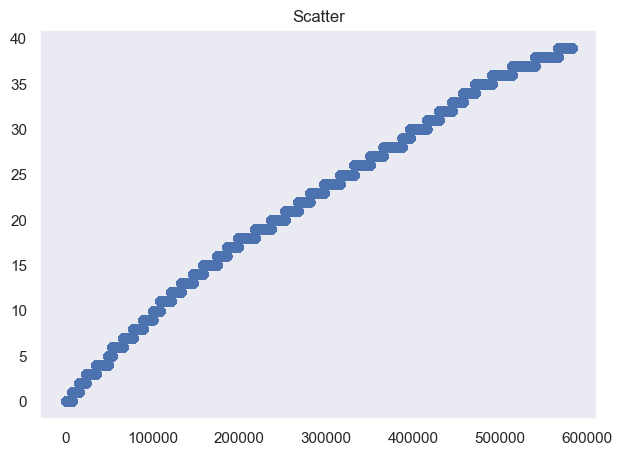

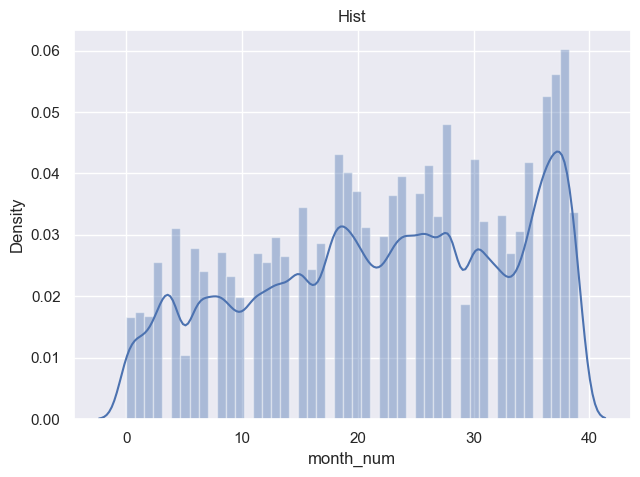


kstest方法：KS检验，

参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差

结果返回两个值：statistic → D值，pvalue → P值

p 值大于0.05，为正态分布 H0:样本符合  H1:样本不符合 如何 p>0.05 接受H0 ,反之 
    
KstestResult(statistic=0.07670043288377981, pvalue=0.0)
变量极差	Max(39.000000)-Min(0.000000) = 39.000000
---频率分布情况---


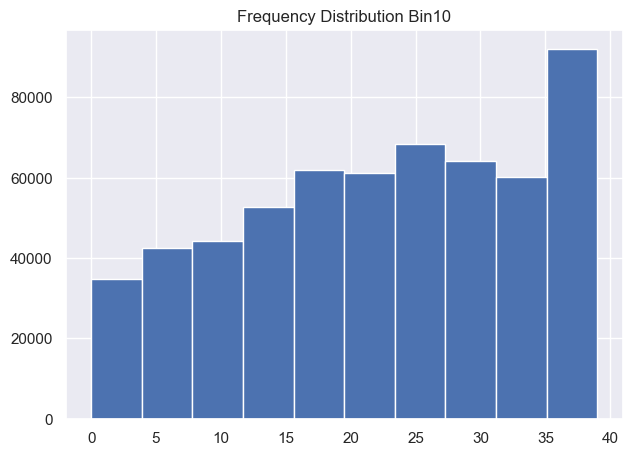

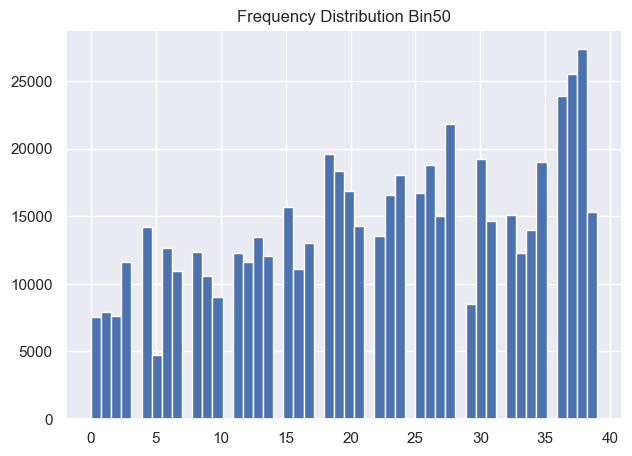

---分组区间---
0    [0.0, 3.9)
1    [0.0, 3.9)
2    [0.0, 3.9)
3    [0.0, 3.9)
4    [0.0, 3.9)
Name: month_num, dtype: category
Categories (10, interval[float64, left]): [[0.0, 3.9) < [3.9, 7.8) < [7.8, 11.7) < [11.7, 15.6) ... [23.4, 27.3) < [27.3, 31.2) < [31.2, 35.1) < [35.1, 39.039)] 
------
[0.0, 3.9)        34713
[3.9, 7.8)        42512
[7.8, 11.7)       44237
[11.7, 15.6)      52805
[15.6, 19.5)      61968
[19.5, 23.4)      61238
[23.4, 27.3)      68508
[27.3, 31.2)      64199
[31.2, 35.1)      60272
[35.1, 39.039)    92162
Name: month_num, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: month_num, dtype: int64
---输出频*表---
                   频数        频率      累计频率     频率%    累计频率%
[0.0, 3.9)      34713  0.059581  0.059581   5.96%    5.96%
[3.9, 7.8)      42512  0.072968  0.132549   7.30%   13.25%
[7.8, 11.7)     44237  0.075928  0.208478   7.59%   20.85%
[11.7, 15.6)    52805  0.090635  0.299112   9.06%   29.91%
[15.6, 19.5)    61968  0.106362  0.405474  10.64%   40.55%
[19.5,

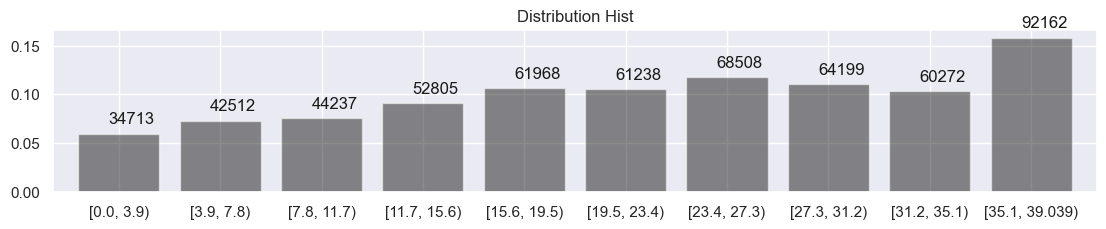

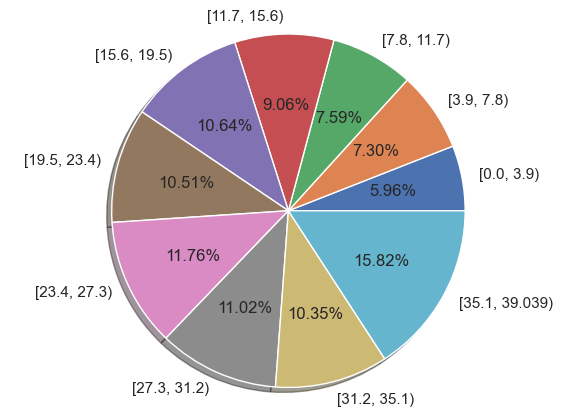

---箱线图---

简单直观的异常值检测方法:箱形图（箱线图）
箱形图中，从上到下依次有 6 个数据节点，分别是上界、上四分位、均值、中位数、下四分位、下界。而那些超过上界的值就会被标记为离群点，也就是异常数据。
    
0          0
1          0
2          0
3          0
4          0
          ..
597689    39
597690    39
597691    39
597692    39
597693    39
Name: month_num, Length: 582614, dtype: int64


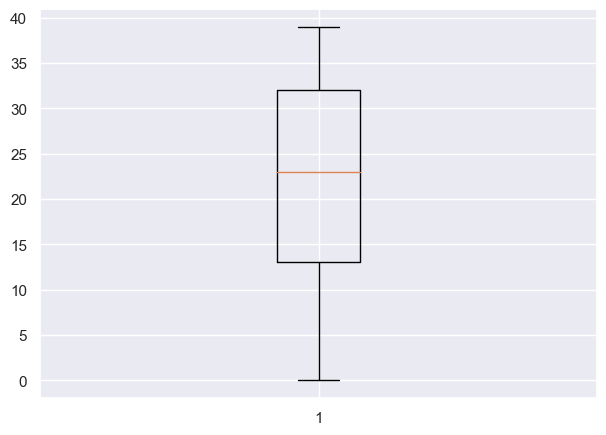




########################## Column region_chan##########################


描述性统计信息,你也可以自己使用下面的方法来做探索

编号     函数           描述
1       count()        非空观测数量
2       sum()          所有值之和
3       mean()         所有值的平均值
4       median()       所有值的中位数
5       mode()         值的模值
6       std()          值的标准偏差
7       min()          所有值中的最小值
8       max()          所有值中的最大值
9       abs()          绝对值
10      prod()         数组元素的乘积
11      cumsum()       累计总和
12      cumprod()      累计乘积
    
---region_chan 描述性信息统计---
count     582614
unique        10
top        102-0
freq      155866
Name: region_chan, dtype: object


region_chan 列中的唯一值和数量如下：

102-0    155866
101-0    116166
105-1    112924
103-0    104639
105-0     49743
104-1     21884
103-1      8842
101-1      6491
102-1      3513
104-0      2546
Name: region_chan, dtype: int64


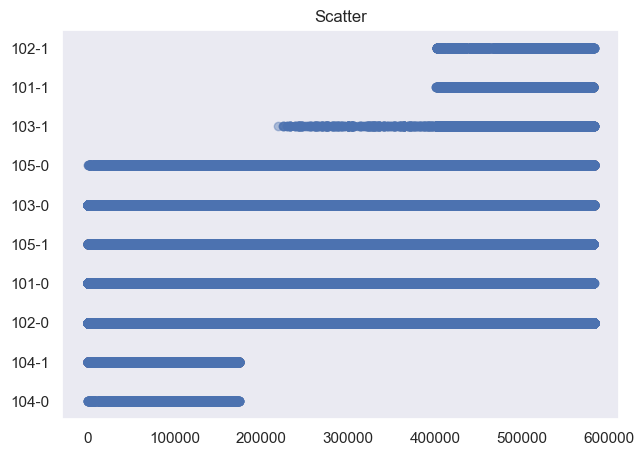

ValueError: could not convert string to float: '104-0'

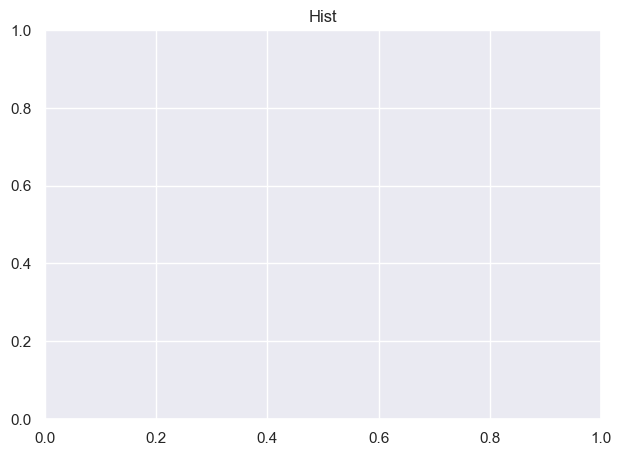

In [22]:
cols = ['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty',
       'dayofmonth', 'dayofweek', 'month', 'year', 'is_month_start',
       'is_month_end', 'is_workday', 'is_holiday', 'in_quarter',
       'in_month_stage', 'month_num', 'region_chan', 'segements_item_price']
for col in cols:
    feature_distribution(data,col)

In [ ]:
def data_reload():
    data = pd.read_csv('order_train1.csv')
    for region in data.sales_region_code.unique():
        indx1 = sigma3(data[data.sales_region_code==region]['ord_qty'])
        indx2 = sigma3(data[data.sales_region_code==region]['item_price'])
        indx = set(indx1).union(indx2)
        data.drop(indx,axis=0,inplace=True)
    data = time_feature(data)
    data['sales_chan_name'] = data['sales_chan_name'].map({'offline':0,'online':1})
    return data

In [23]:
data.to_csv('LincolnTemp.csv')

In [ ]:
data

## 列特征组合探索

商品可能同属于两个类别吗

In [ ]:
data_cp = data[['item_code','first_cate_code','second_cate_code']]
# 如果同属于两个类别，那么至少存在两条不完全相同的记录
for item in data_cp.item_code.unique():
    temp_df = data_cp[data_cp.item_code==item]
    temp_df = temp_df.drop_duplicates(keep='last')
    if len(temp_df)>1:
        print(temp_df)

销售区域+时间

In [ ]:
# 每周七天
# 每周的第一天需求量都最小
df_grouped = data.groupby(['sales_region_code', 'dayofweek'])['ord_qty'].sum()
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='dayofweek', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# 每年的需求量
df_grouped = data.groupby(['sales_region_code', 'year'])['ord_qty'].sum()
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='year', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('ord_qty')
plt.show()


In [ ]:
# 月初0     月中1       月末2
# 月末>月中>月初
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='in_month_stage', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# 每个季度
# 2015年只有最后一季度，比较删除前后的情况
# 第四季度需求量最大
data_cp = data[data.year>2015]

# df_pivot = pd.pivot_table(data_cp, index='sales_region_code', columns='in_quarter', values='ord_qty',
#                           aggfunc=np.sum)
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='in_quarter', values='ord_qty',
                          aggfunc=np.sum)
plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('ord_qty')
plt.show()

销售区域+大类细类

In [ ]:
# 306每个地区需求量都高
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='first_cate_code', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='second_cate_code', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# 每一年每个月的需求量变化
ord_qty_lst = {}
for i in range(2015,2019):
    ord_qty = pd.DataFrame(data[data.year==i].groupby('month')['ord_qty'].sum().reset_index())
    ord_qty.columns=['month','ord_qty_sum']
    ord_qty_lst[f'ord_qty_{i}'] = ord_qty
    
for i in range(1,9):
    df1 = pd.DataFrame([[j for j in range(2)]], columns=['month','ord_qty_sum'])
    df1.iloc[0,0] = i
    df1.iloc[0,1] = 0
    ord_qty_lst['ord_qty_2015'] = ord_qty_lst['ord_qty_2015'].append(df1)
    
# 数据合并
for i in range(2015,2018):
        if i==2015:
                final = ord_qty_lst['ord_qty_2015'].merge(ord_qty_lst['ord_qty_2016'],on='month')
        else:
                final = final.merge(ord_qty_lst[f'ord_qty_{i+1}'],on='month') 
  
final.sort_values('month',inplace=True)          
final.columns=['month','ord_qty_2015','ord_qty_2016','ord_qty_2017','ord_qty_2018']
px.line(final, x = 'month', y = ['ord_qty_2015','ord_qty_2016','ord_qty_2017','ord_qty_2018'],
        title='month_ord_qty',template = 'plotly_dark')

销售区域、大类细类+时间

In [ ]:
# 每个地区、每个大类、每个月的需求量情况
# 101，102，103地区的整体需求量变化趋势几乎完全相同
# 104，105地区整体需求量变化趋势几乎完全相同，且不同于前三个地区

def ord_daily_first(data):
    item_ts_data = []
    for first_code  in data.first_cate_code.unique():
        temp_item_df = data[data.first_cate_code==first_code].groupby('month')['ord_qty'].sum().reset_index()
        item_ts_data.append(go.Scatter(x=temp_item_df.month, y=temp_item_df.ord_qty, 
                                       name = str(first_code)))
    py.iplot(item_ts_data)

for region in [101,102,103,104,105]:
    data_cp = data.copy()
    data_cp = data_cp[data_cp.sales_region_code==region]
    ord_daily_first(data_cp)

In [ ]:
# 每个地区、每个细类、每个月的需求量情况
def ord_daily_second(data):
    item_ts_data = []
    for second_code  in data.second_cate_code.unique():
        temp_item_df = data[data.second_cate_code==second_code].groupby('month')['ord_qty'].sum().reset_index()
        item_ts_data.append(go.Scatter(x=temp_item_df.month, y=temp_item_df.ord_qty, 
                                       name = str(second_code)))
    py.iplot(item_ts_data)

for region in [101,102,103,104,105]:
    data_cp = data.copy()
    data_cp = data_cp[data_cp.sales_region_code==region]
    ord_daily_second(data_cp)

销售区域+销售渠道

In [ ]:
# 104，105地区的线上需求量更大
# 其余地区均线下需求量更大
temp_df = data.groupby(['sales_region_code','sales_chan_name'])
region_chan_df= temp_df['ord_qty'].sum().reset_index(name='sum')

fig, ax = plt.subplots()
ax.bar(x=region_chan_df.index, height=region_chan_df['sum'])
ax.set_xticks(region_chan_df.index)
ax.set_xticklabels(region_chan_df.apply(lambda x: f"{x['sales_region_code']}-{x['sales_chan_name']}", axis=1), rotation=90)
plt.show()


销售区域、销售渠道+时间

In [ ]:
# 每个地区、每个大类、每个月的需求量情况
def ord_daily_first(data):
    item_ts_data = []
    for chan  in data.sales_chan_name.unique():
        temp_item_df = data[data.sales_chan_name==chan].groupby('month')['ord_qty'].sum().reset_index()
        item_ts_data.append(go.Scatter(x=temp_item_df.month, y=temp_item_df.ord_qty, 
                                       name = str(chan)))
    py.iplot(item_ts_data)

for region in [101,102,103,104,105]:
    data_cp = data.copy()
    data_cp = data_cp[data_cp.sales_region_code==region]
    ord_daily_first(data_cp)

大类细类+时间

In [ ]:
# 大类，一周的每天
df_pivot = pd.pivot_table(data, index='first_cate_code', columns='dayofweek', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('first_cate_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# 大类，每年
df_pivot = pd.pivot_table(data, index='first_cate_code', columns='year', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('first_cate_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# 月初月中月末
df_pivot = pd.pivot_table(data, index='first_cate_code', columns='in_month_stage', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('first_cate_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
df_pivot = pd.pivot_table(data, index='first_cate_code', columns='month', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('first_cate_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# # 细类，一周的每天
df_pivot = pd.pivot_table(data, index='second_cate_code', columns='dayofweek', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('second_cate_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
# 细类，每年
df_pivot = pd.pivot_table(data, index='second_cate_code', columns='year', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('second_cate_code')
plt.ylabel('ord_qty')
plt.show()

In [ ]:
df_pivot = pd.pivot_table(data, index='second_cate_code', columns='in_month_stage', values='ord_qty',
                          aggfunc=np.sum)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('second_cate_code')
plt.ylabel('ord_qty')
plt.show()

大类细类+销售渠道

In [ ]:

temp_df = data.groupby(['first_cate_code','sales_chan_name'])
first_chan_df= temp_df['ord_qty'].sum().reset_index(name='sum')

fig, ax = plt.subplots()
ax.bar(x=first_chan_df.index, height=first_chan_df['sum'])
ax.set_xticks(first_chan_df.index)
ax.set_xticklabels(first_chan_df.apply(lambda x: f"{x['first_cate_code']}-{x['sales_chan_name']}", axis=1), rotation=90)
plt.show()

In [ ]:
temp_df = data.groupby(['second_cate_code','sales_chan_name'])
second_chan_df= temp_df['ord_qty'].sum().reset_index(name='sum')

fig, ax = plt.subplots()
ax.bar(x=second_chan_df.index, height=second_chan_df['sum'])
ax.set_xticks(second_chan_df.index)
ax.set_xticklabels(second_chan_df.apply(lambda x: f"{x['second_cate_code']}-{x['sales_chan_name']}", axis=1), rotation=90)
plt.show()

销售区域，大类细类+价格

In [ ]:
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='first_cate_code', values='item_price',
                          aggfunc=np.median)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('median_price')
plt.show()

In [ ]:
df_pivot = pd.pivot_table(data, index='sales_region_code', columns='second_cate_code', values='item_price',
                          aggfunc=np.median)

plt.figure(figsize=(10, 6))
df_pivot.plot(kind='bar',width=0.8)
plt.legend(loc='best',fontsize=6)
plt.xlabel('sales_region_code')
plt.ylabel('median_price')
plt.show()

产品价格对需求量的影响

In [ ]:
plt.scatter(data['item_price'], data['ord_qty'])
plt.xlabel('item_price')
plt.ylabel('ord_qty')
plt.title('item_price and ord_qty')
plt.show()

In [ ]:
data['item_price_group'] = pd.cut(data['item_price'], bins=range(0, 6100, 1000))
# 画出分组后数据和ord_qty的散点图
plt.scatter(data['item_price_group'].apply(lambda x: x.mid), data['ord_qty'])
plt.xlabel('Item Price Group')
plt.ylabel('Order Quantity')
plt.show()